# Intuitive Evaluation of MLM performance of Transformer Models on Nepali text using Cosine Similarity

In [1]:
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

## Steps for Evaluation

1. Given a text with a Masked Word
2. Model predicts top N=5 words
3. Calculate Cosine Similarities between Masked Word and N=5 Predicted Words
4. Calculate Mean Cosine Similarity.
5. Define a threshold=0.5 value for 'Good' model. \
    5.1. IF mean_similarity == 1 (exact word match) OR mean_similarity >= threshold+0.2 (more similar), THEN model is 'Very Good' \
    5.2. IF mean_similarity < threshold+0.2 AND mean_similarity >= threshold, THEN model is 'Good' \
    5.3. IF mean_similarity < threshold AND mean_similarity >= threshold-0.2, THEN model is 'Okay' \
    5.4. ELSE model is 'Bad'

## Experimental Usage

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display

pd.options.display.max_colwidth = 1000

In [3]:
def bold(text):
    return "\033[1m" + text + "\033[0m"

### Load Word2Vec model

Using **npVec1: Word2Vec** model to load word vectors.

In [4]:
from gensim.models import Word2Vec
model = 'word2vec/processed.word2vec'
wv = Word2Vec.load(model)
vocab = list(wv.wv.key_to_index.keys())

### Methods for model evaluation

In [5]:
# Get word similarities between a word and list of words
def get_word_similarities(word, test_words):
    word = word.strip()
    similarities = []
    word_similarities = {}
    print(f'Cosine Similarity between masked word and predicted words:')
    for t_word in test_words:
        t_word = t_word.strip()
        t_word = t_word.replace('#', '') # Cleaning for WordPiece token predictions
        if word in vocab and t_word in vocab:
            cosine_similarity = wv.wv.similarity(word, t_word)
            similarities.append(cosine_similarity)
            print(f'{word}, {t_word} ==> {cosine_similarity:.4f}')
            word_similarities[t_word] = np.round(cosine_similarity, 4)
        elif t_word not in vocab:
            print(f'{t_word} not found in vocab!')
            
    print(f'\nMean: {np.array(similarities).mean():.4f}')
    return word_similarities

# Evaluate Model by cosine similarities
def evaluate(tf_model, similarities, good_threshold):
    mean = np.array(list(similarities.values())).mean()
    model_quality = 'Unknown'
    
    if max(similarities.values()) == 1 or mean >= good_threshold + 0.2:
        model_quality = 'Very Good'
    elif mean >= good_threshold:
        model_quality = 'Good'
    elif mean >= good_threshold - 0.2:
        model_quality = 'Okay'
    else:
        model_quality = 'Bad'
    print(f'{bold(tf_model.name)}: {bold(tf_model.hfid)} ==> {bold(model_quality)}')
    
    return model_quality

# Given a model, sentence, and mask token index, evaluate model quality
def interpret_model(tf_model, sentence, mask_token_index, good_threshold=0.5):
    masked_word, predicted_words, df = predict_masked_token(tf_model, sentence=sentence, mask_token_index=mask_token_index)
    display(df)

    word_similarities = get_word_similarities(masked_word, predicted_words)

    interpretation_result = evaluate(tf_model, word_similarities, good_threshold)
    
    return interpretation_result

### Load Models

In [28]:
model = {
    'bertrajan': {
        'name': 'BERT Rajan', 
        'hfid': 'Rajan/NepaliBERT'
    },
    'bertnpvec1': {
        'name': 'BERT NpVec1',
        'hfid': 'nowalab/nepali-bert-npvec1'
    },
    'bertshushant': {
        'name': 'BERT Shushant',
        'hfid': 'Shushant/nepaliBERT'
    },
    'bertnepberta': {
        'name': 'BERT NepBERTa',
        'hfid': 'NepBERTa/NepBERTa'
    },
    'bertoya': {
        'name': 'BERT Oya',
        'hfid': 'oya163/NepBERT'
    },
    'roberta': {
        'name': 'RoBERTa', 
        'hfid': 'amitness/nepbert'
    },
    'distilbert': {
        'name': 'DistilBERT', 
        'hfid': 'Sakonii/distilbert-base-nepali'
    },
    'deberta': {
        'name': 'DeBERTa', 
        'hfid': 'Sakonii/deberta-base-nepali'
    },
    'mbertu': {
        'name': 'mBERT-uncased', 
        'hfid': 'bert-base-multilingual-uncased'
    },
    'mbertc': {
        'name': 'mBERT-cased', 
        'hfid': 'bert-base-multilingual-cased'
    },
    'xlmroberta': {
        'name': 'XLMRoBERTa', 
        'hfid': 'xlm-roberta-base'
    },
    'hindiroberta': {
        'name': 'HindiRoBERTa', 
        'hfid': 'flax-community/roberta-hindi'
    }
}

In [13]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForMaskedLM

class TransformerModel:
    
    def __init__(self, model, load_tokenizer=True, load_model=True, from_tf=False):
        self.name = model['name']
        self.hfid = model['hfid']
        
        # Load Tokenizer, Model and Pipeline
        self.model, self.tokenizer = self.load_model_and_tokenizer(self.hfid, load_tokenizer, load_model, from_tf)
        self.pipeline = self.load_pipeline(self.model, self.tokenizer)


    def load_model_and_tokenizer(self, hfid, load_tokenizer, load_model, from_tf):
        if load_tokenizer:
            tokenizer = AutoTokenizer.from_pretrained(hfid, strip_accents=False, clean_text=False)
            print(f"{self.name}: {self.hfid} tokenizer loaded.")
            
        if load_model:
            model = AutoModelForMaskedLM.from_pretrained(hfid, from_tf=from_tf)
            print(f"{self.name}: {self.hfid} model loaded.")
            
        return model, tokenizer
            
    def load_pipeline(self, model, tokenizer):
        p_line = pipeline('fill-mask', model=model, tokenizer=tokenizer)
        print(f"{self.name}: {self.hfid} 'fill-mask' pipeline loaded.")
        return p_line

### Methods for Masking and Unmasking using Model Pipelines

In [8]:
# Used to reconstruct word which is splitted on characters by a space
def clean_token_str(token):
    return ''.join(token.split())

def find_word_index(word, sentence):
    return sentence.split().index(word)

# Masks the input sentence at random word index if mask_token_index is not given
def mask_sentence(tf_model, sentence, mask_token_index=None):
    print('Sentence: ', sentence)

    # Mask random word if index is not given
    words = sentence.split()
    if mask_token_index == None:
        mask_token_index = np.random.randint(len(words))

    # Mask token at given index with model-specific mask token
    masked_word = words[mask_token_index]
    print('Masked Word: ', masked_word)

    words[mask_token_index] = tf_model.tokenizer.mask_token
    masked_sentence = ' '.join(words)
    print('Masked Sentence: ', masked_sentence)

    return masked_word, masked_sentence

# First mask the given sentence, then Unmasks them according to the loaded models. Result is a Pandas dataframe
def predict_masked_token(tf_model, sentence, mask_token=None, mask_token_index=None):
    print(f"\n{'-'*15} {tf_model.name}: {tf_model.hfid} {'-'*15}\n")
    masked_word, masked_sentence = mask_sentence(tf_model, sentence, mask_token_index)

    prediction_result = tf_model.pipeline(masked_sentence)
    df = pd.DataFrame(prediction_result)

    predicted_words = df.token_str.values.tolist()

    return masked_word, predicted_words, df

## Usage

### Load Transformer Models

In [9]:
bertrajan = TransformerModel(model['bertrajan'])

BERT Rajan: Rajan/NepaliBERT tokenizer loaded.
BERT Rajan: Rajan/NepaliBERT model loaded.
BERT Rajan: Rajan/NepaliBERT 'fill-mask' pipeline loaded.


In [10]:
bertnpvec1 = TransformerModel(model['bertnpvec1'])

Downloading: 100%|██████████| 466/466 [00:00<00:00, 671kB/s]
Downloading: 100%|██████████| 540k/540k [00:01<00:00, 330kB/s] 


BERT NpVec1: nowalab/nepali-bert-npvec1 tokenizer loaded.


Downloading: 100%|██████████| 90.5M/90.5M [00:06<00:00, 14.3MB/s]


BERT NpVec1: nowalab/nepali-bert-npvec1 model loaded.
BERT NpVec1: nowalab/nepali-bert-npvec1 'fill-mask' pipeline loaded.


In [29]:
bertshushant = TransformerModel(model['bertshushant'])

Downloading: 100%|██████████| 589/589 [00:00<00:00, 670kB/s]
Downloading: 100%|██████████| 529k/529k [00:01<00:00, 282kB/s]  


BERT Shushant: Shushant/nepaliBERT tokenizer loaded.


Downloading: 100%|██████████| 438M/438M [00:25<00:00, 17.4MB/s]   


BERT Shushant: Shushant/nepaliBERT model loaded.
BERT Shushant: Shushant/nepaliBERT 'fill-mask' pipeline loaded.


In [16]:
bertoya = TransformerModel(model['bertoya'])

Downloading: 100%|██████████| 16.0/16.0 [00:00<00:00, 17.8kB/s]
Downloading: 100%|██████████| 497/497 [00:00<00:00, 526kB/s]
Downloading: 100%|██████████| 972k/972k [00:02<00:00, 389kB/s]  
Downloading: 100%|██████████| 514k/514k [00:01<00:00, 285kB/s]  
Downloading: 100%|██████████| 150/150 [00:00<00:00, 164kB/s]


BERT Oya: oya163/NepBERT tokenizer loaded.


Downloading: 100%|██████████| 334M/334M [00:20<00:00, 16.6MB/s]   
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at oya163/NepBERT and are newly initialized: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Oya: oya163/NepBERT model loaded.
BERT Oya: oya163/NepBERT 'fill-mask' pipeline loaded.


In [17]:
roberta = TransformerModel(model['roberta'])

RoBERTa: amitness/nepbert tokenizer loaded.
RoBERTa: amitness/nepbert model loaded.
RoBERTa: amitness/nepbert 'fill-mask' pipeline loaded.


In [18]:
distilbert = TransformerModel(model['distilbert'])

DistilBERT: Sakonii/distilbert-base-nepali tokenizer loaded.
DistilBERT: Sakonii/distilbert-base-nepali model loaded.
DistilBERT: Sakonii/distilbert-base-nepali 'fill-mask' pipeline loaded.


In [19]:
deberta = TransformerModel(model['deberta'])

DeBERTa: Sakonii/deberta-base-nepali tokenizer loaded.
DeBERTa: Sakonii/deberta-base-nepali model loaded.
DeBERTa: Sakonii/deberta-base-nepali 'fill-mask' pipeline loaded.


In [20]:
mbert = TransformerModel(model['mbertu'])

mBERT-uncased: bert-base-multilingual-uncased tokenizer loaded.


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


mBERT-uncased: bert-base-multilingual-uncased model loaded.
mBERT-uncased: bert-base-multilingual-uncased 'fill-mask' pipeline loaded.


In [21]:
xlmroberta = TransformerModel(model['xlmroberta'])

XLMRoBERTa: xlm-roberta-base tokenizer loaded.
XLMRoBERTa: xlm-roberta-base model loaded.
XLMRoBERTa: xlm-roberta-base 'fill-mask' pipeline loaded.


In [22]:
hindiroberta = TransformerModel(model['hindiroberta'])

HindiRoBERTa: flax-community/roberta-hindi tokenizer loaded.
HindiRoBERTa: flax-community/roberta-hindi model loaded.
HindiRoBERTa: flax-community/roberta-hindi 'fill-mask' pipeline loaded.


In [23]:
mbertcased = TransformerModel(model['mbertc'])

mBERT-cased: bert-base-multilingual-cased tokenizer loaded.


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


mBERT-cased: bert-base-multilingual-cased model loaded.
mBERT-cased: bert-base-multilingual-cased 'fill-mask' pipeline loaded.


### Define a sample sentence

In [24]:
sentence = 'कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ'

### Interpret Models

In [25]:
interpret_model(bertrajan, sentence, -3)


--------------- BERT Rajan: Rajan/NepaliBERT ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले [MASK] बनाएको छ


,score,token,token_str,sequence
0,0.045957,6855,निराश,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले निराश बनाएको छ
1,0.031623,2584,प्रभावित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले प्रभावित बनाएको छ
2,0.029524,8417,चिन्तित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
3,0.023314,3028,खुसी,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले खुसी बनाएको छ
4,0.020482,2647,कमजोर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले कमजोर बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, निराश ==> 0.6721
चिन्तित, प्रभावित ==> 0.3963
चिन्तित, चिन्तित ==> 1.0000
चिन्तित, खुसी ==> 0.5382
चिन्तित, कमजोर ==> 0.3513

Mean: 0.5916
BERT Rajan: Rajan/NepaliBERT ==> Very Good


'Very Good'

In [30]:
interpret_model(bertshushant, sentence, -3)


--------------- BERT Shushant: Shushant/nepaliBERT ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले [MASK] बनाएको छ


,score,token,token_str,sequence
0,0.135544,1025,##त,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेत बनाएको छ
1,0.084679,1022,##य,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेय बनाएको छ
2,0.065637,1064,##ध,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेध बनाएको छ
3,0.049594,1687,##ति,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेति बनाएको छ
4,0.029715,8936,##तर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेतर बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, त ==> 0.1095
चिन्तित, य ==> 0.1089
चिन्तित, ध ==> 0.0448
चिन्तित, ति ==> 0.0776
चिन्तित, तर ==> 0.1413

Mean: 0.0964
BERT Shushant: Shushant/nepaliBERT ==> Bad


'Bad'

In [31]:
interpret_model(bertnpvec1, sentence, -3)


--------------- BERT NpVec1: nowalab/nepali-bert-npvec1 ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले [MASK] बनाएको छ


,score,token,token_str,sequence
0,0.177189,53,ल,कोभिड मुक्त यतिबेला युद्धको चिन्ताले ल बनाएको छ
1,0.034878,168,मा,कोभिड मुक्त यतिबेला युद्धको चिन्ताले मा बनाएको छ
2,0.034231,97,##त,कोभिड मुक्त यतिबेला युद्धको चिन्तालेत बनाएको छ
3,0.034170,17411,##रमण,कोभिड मुक्त यतिबेला युद्धको चिन्तालेरमण बनाएको छ
4,0.032915,522,घर,कोभिड मुक्त यतिबेला युद्धको चिन्ताले घर बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, ल ==> 0.0077
चिन्तित, मा ==> 0.0799
चिन्तित, त ==> 0.1095
चिन्तित, रमण ==> 0.0380
चिन्तित, घर ==> 0.1576

Mean: 0.0785
BERT NpVec1: nowalab/nepali-bert-npvec1 ==> Bad


'Bad'

In [32]:
interpret_model(bertoya, sentence, -3)


--------------- BERT Oya: oya163/NepBERT ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


,score,token,token_str,sequence
0,0.001317,36453,नबम,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेनबम बनाएको छ
1,0.001093,17992,बलम,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले बलम बनाएको छ
2,0.001026,34740,२०३८,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले २०३८ बनाएको छ
3,0.000989,37444,झर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेझर बनाएको छ
4,0.000927,28891,नढ,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेनढ बनाएको छ


Cosine Similarity between masked word and predicted words:
नबम not found in vocab!
चिन्तित, बलम ==> -0.0298
२०३८ not found in vocab!
चिन्तित, झर ==> 0.0750
नढ not found in vocab!

Mean: 0.0226
BERT Oya: oya163/NepBERT ==> Bad


'Bad'

In [33]:
interpret_model(roberta, sentence, -3)


--------------- RoBERTa: amitness/nepbert ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


,score,token,token_str,sequence
0,0.391272,998,सहज,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले सहज बनाएको छ
1,0.126537,596,घर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले घर बनाएको छ
2,0.092316,711,सफल,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले सफल बनाएको छ
3,0.057050,1606,असफल,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले असफल बनाएको छ
4,0.031131,730,सडक,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले सडक बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, सहज ==> 0.1584
चिन्तित, घर ==> 0.1576
चिन्तित, सफल ==> 0.1761
चिन्तित, असफल ==> 0.2581
चिन्तित, सडक ==> 0.0731

Mean: 0.1647
RoBERTa: amitness/nepbert ==> Bad


'Bad'

In [34]:
interpret_model(mbert, sentence, -3)


--------------- mBERT-uncased: bert-base-multilingual-uncased ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले [MASK] बनाएको छ


,score,token,token_str,sequence
0,0.810321,100,[UNK],कोभिड पीडाबाट मानव समाजलाई बनाएको छ
1,0.010490,566,न,कोभिड पीडाबाट मानव समाजलाई न बनाएको छ
2,0.005811,41426,रपमा,कोभिड पीडाबाट मानव समाजलाई रपमा बनाएको छ
3,0.005600,107,"""","कोभिड पीडाबाट मानव समाजलाई "" बनाएको छ"
4,0.004687,23213,पनि,कोभिड पीडाबाट मानव समाजलाई पनि बनाएको छ


Cosine Similarity between masked word and predicted words:
[UNK] not found in vocab!
चिन्तित, न ==> 0.0761
चिन्तित, रपमा ==> 0.0028
" not found in vocab!
चिन्तित, पनि ==> 0.1515

Mean: 0.0768
mBERT-uncased: bert-base-multilingual-uncased ==> Bad


'Bad'

In [35]:
interpret_model(hindiroberta, sentence, -3)


--------------- HindiRoBERTa: flax-community/roberta-hindi ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


,score,token,token_str,sequence
0,0.087568,348,कर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेकर बनाएको छ
1,0.065402,263,क,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेक बनाएको छ
2,0.058967,297,न,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले न बनाएको छ
3,0.041494,270,न,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेन बनाएको छ
4,0.038912,272,स,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेस बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, कर ==> 0.0947
चिन्तित, क ==> 0.0715
चिन्तित, न ==> 0.0761
चिन्तित, न ==> 0.0761
चिन्तित, स ==> 0.0766

Mean: 0.0790
HindiRoBERTa: flax-community/roberta-hindi ==> Bad


'Bad'

In [36]:
interpret_model(distilbert, sentence, -3)


--------------- DistilBERT: Sakonii/distilbert-base-nepali ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


,score,token,token_str,sequence
0,0.611475,6655,चिन्तित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
1,0.174322,18338,आक्रान्त,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले आक्रान्त बनाएको छ
2,0.058475,6818,स्तब्ध,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले स्तब्ध बनाएको छ
3,0.034532,14780,त्रसित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले त्रसित बनाएको छ
4,0.013073,6681,निराश,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले निराश बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, चिन्तित ==> 1.0000
चिन्तित, आक्रान्त ==> 0.4852
चिन्तित, स्तब्ध ==> 0.4729
चिन्तित, त्रसित ==> 0.6415
चिन्तित, निराश ==> 0.6721

Mean: 0.6543
DistilBERT: Sakonii/distilbert-base-nepali ==> Very Good


'Very Good'

In [37]:
interpret_model(deberta, sentence, -3)


--------------- DeBERTa: Sakonii/deberta-base-nepali ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


,score,token,token_str,sequence
0,0.360634,18338,आक्रान्त,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले आक्रान्त बनाएको छ
1,0.150190,6655,चिन्तित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
2,0.111567,1977,मुक्त,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले मुक्त बनाएको छ
3,0.097666,15059,ग्रसित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले ग्रसित बनाएको छ
4,0.042191,1246,पीडित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले पीडित बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, आक्रान्त ==> 0.4852
चिन्तित, चिन्तित ==> 1.0000
चिन्तित, मुक्त ==> 0.2041
चिन्तित, ग्रसित ==> 0.3866
चिन्तित, पीडित ==> 0.2917

Mean: 0.4735
DeBERTa: Sakonii/deberta-base-nepali ==> Very Good


'Very Good'

In [38]:
interpret_model(xlmroberta, sentence, -3)


--------------- XLMRoBERTa: xlm-roberta-base ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


,score,token,token_str,sequence
0,0.235344,154558,बाध्य,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले बाध्य बनाएको छ
1,0.078123,112326,गम्भीर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले गम्भीर बनाएको छ
2,0.077793,87539,कमजोर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले कमजोर बनाएको छ
3,0.045162,213750,पीडा,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले पीडा बनाएको छ
4,0.045061,84877,दुःख,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले दुःख बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, बाध्य ==> 0.3906
चिन्तित, गम्भीर ==> 0.3560
चिन्तित, कमजोर ==> 0.3513
चिन्तित, पीडा ==> 0.2556
चिन्तित, दुःख ==> 0.2993

Mean: 0.3306
XLMRoBERTa: xlm-roberta-base ==> Okay


'Okay'

In [39]:
interpret_model(distilbert, 'नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।', 10)


--------------- DistilBERT: Sakonii/distilbert-base-nepali ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप <mask> छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


,score,token,token_str,sequence
0,0.419864,12540,मनाउँदै,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप मनाउँदै छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
1,0.332223,4843,खेल्दै,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप खेल्दै छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
2,0.139821,2920,जितेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
3,0.027668,2034,खेल्ने,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप खेल्ने छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
4,0.011618,4245,खेलेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप खेलेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


Cosine Similarity between masked word and predicted words:
जितेको, मनाउँदै ==> 0.1996
जितेको, खेल्दै ==> 0.2521
जितेको, जितेको ==> 1.0000
जितेको, खेल्ने ==> 0.2186
जितेको, खेलेको ==> 0.4432

Mean: 0.4227
DistilBERT: Sakonii/distilbert-base-nepali ==> Very Good


'Very Good'

### Evaluating on Multiple sentences (experiments)

In [40]:
models = [bertrajan, bertshushant, bertnpvec1, bertoya, roberta, distilbert, deberta, mbert, xlmroberta, hindiroberta, mbertcased]
print(f'Evaluating {len(models)} models.')

Evaluating 11 models.


In [41]:
sentences = [
    ('थाइल्याण्डको राजधानी बैंकक हो ।', 'बैंकक'),
    ('भारतको राजधानी नयाँदिल्ली हो ।', 'नयाँदिल्ली'),
    ('म राति सुत्नु अगाडि दाँत माझ्छु ।', 3),
    ('कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ', 'चिन्तित'),
    ('नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।', 'श्रीलंका'),
    ('नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।', 4),
    ('एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।', 'आमा'),
    ('परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।', 'राम्रो'),
    ('नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।', 'जितेको')
]

In [42]:
data_index = []
data = []

for idx, (sentence, mask) in enumerate(sentences):
    print(f'\n================== SENTENCE {idx+1} ==================')
    result = {}
    data_index.append(f'Sent {idx+1}')
        
    mask_token_index = mask
    if isinstance(mask, str):
        mask_token_index = find_word_index(mask, sentence)
        
    for model in models:
        model_quality = interpret_model(model, sentence, mask_token_index)
        result[model.name] = model_quality
        
    data.append(result)
        
df = pd.DataFrame(data)
display(df)


================== SENTENCE 1 ==================

--------------- BERT Rajan: Rajan/NepaliBERT ---------------

Sentence:  थाइल्याण्डको राजधानी बैंकक हो ।
Masked Word:  बैंकक
Masked Sentence:  थाइल्याण्डको राजधानी [MASK] हो ।


,score,token,token_str,sequence
0,0.117888,557,पनि,थाइल्याण्डको राजधानी पनि हो ।
1,0.035787,2793,राजधानी,थाइल्याण्डको राजधानी राजधानी हो ।
2,0.023385,1633,यही,थाइल्याण्डको राजधानी यही हो ।
3,0.021396,2186,पोखरा,थाइल्याण्डको राजधानी पोखरा हो ।
4,0.018002,859,प्रदेश,थाइल्याण्डको राजधानी प्रदेश हो ।


Cosine Similarity between masked word and predicted words:
बैंकक, पनि ==> 0.1408
बैंकक, राजधानी ==> 0.2759
बैंकक, यही ==> 0.1605
बैंकक, पोखरा ==> 0.3081
बैंकक, प्रदेश ==> 0.0989

Mean: 0.1968
BERT Rajan: Rajan/NepaliBERT ==> Bad

--------------- BERT Shushant: Shushant/nepaliBERT ---------------

Sentence:  थाइल्याण्डको राजधानी बैंकक हो ।
Masked Word:  बैंकक
Masked Sentence:  थाइल्याण्डको राजधानी [MASK] हो ।


,score,token,token_str,sequence
0,0.336487,5848,काठमाडौ,थाइल्याण्डको राजधानी काठमाडौ हो ।
1,0.160264,1724,पनि,थाइल्याण्डको राजधानी पनि हो ।
2,0.121443,386,न,थाइल्याण्डको राजधानी न हो ।
3,0.050106,4552,विराटनगर,थाइल्याण्डको राजधानी विराटनगर हो ।
4,0.046713,2909,यही,थाइल्याण्डको राजधानी यही हो ।


Cosine Similarity between masked word and predicted words:
बैंकक, काठमाडौ ==> 0.3400
बैंकक, पनि ==> 0.1408
बैंकक, न ==> 0.0683
बैंकक, विराटनगर ==> 0.2780
बैंकक, यही ==> 0.1605

Mean: 0.1975
BERT Shushant: Shushant/nepaliBERT ==> Bad

--------------- BERT NpVec1: nowalab/nepali-bert-npvec1 ---------------

Sentence:  थाइल्याण्डको राजधानी बैंकक हो ।
Masked Word:  बैंकक
Masked Sentence:  थाइल्याण्डको राजधानी [MASK] हो ।


,score,token,token_str,sequence
0,0.050575,165,को,थाइल्याण्डको को हो ।
1,0.035853,217,पनि,थाइल्याण्डको पनि हो ।
2,0.029010,43,न,थाइल्याण्डको न हो ।
3,0.024303,39,त,थाइल्याण्डको त हो ।
4,0.022876,722,आयोजना,थाइल्याण्डको आयोजना हो ।


Cosine Similarity between masked word and predicted words:
बैंकक, को ==> 0.1387
बैंकक, पनि ==> 0.1408
बैंकक, न ==> 0.0683
बैंकक, त ==> 0.1184
बैंकक, आयोजना ==> 0.0658

Mean: 0.1064
BERT NpVec1: nowalab/nepali-bert-npvec1 ==> Bad

--------------- BERT Oya: oya163/NepBERT ---------------

Sentence:  थाइल्याण्डको राजधानी बैंकक हो ।
Masked Word:  बैंकक
Masked Sentence:  थाइल्याण्डको राजधानी <mask> हो ।


,score,token,token_str,sequence
0,0.001317,36453,नबम,थाइल्याण्डको राजधानीनबम हो ।
1,0.001093,17992,बलम,थाइल्याण्डको राजधानी बलम हो ।
2,0.001026,34740,२०३८,थाइल्याण्डको राजधानी २०३८ हो ।
3,0.000989,37444,झर,थाइल्याण्डको राजधानीझर हो ।
4,0.000927,28891,नढ,थाइल्याण्डको राजधानीनढ हो ।


Cosine Similarity between masked word and predicted words:
नबम not found in vocab!
बैंकक, बलम ==> 0.1297
२०३८ not found in vocab!
बैंकक, झर ==> 0.0869
नढ not found in vocab!

Mean: 0.1083
BERT Oya: oya163/NepBERT ==> Bad

--------------- RoBERTa: amitness/nepbert ---------------

Sentence:  थाइल्याण्डको राजधानी बैंकक हो ।
Masked Word:  बैंकक
Masked Sentence:  थाइल्याण्डको राजधानी <mask> हो ।


,score,token,token_str,sequence
0,0.466835,370,एक,थाइल्याण्डको राजधानी एक हो ।
1,0.046690,313,त,थाइल्याण्डको राजधानी त हो ।
2,0.033155,572,समय,थाइल्याण्डको राजधानी समय हो ।
3,0.021578,1272,सहर,थाइल्याण्डको राजधानी सहर हो ।
4,0.021470,1202,शहर,थाइल्याण्डको राजधानी शहर हो ।


Cosine Similarity between masked word and predicted words:
बैंकक, एक ==> 0.1290
बैंकक, त ==> 0.1184
बैंकक, समय ==> 0.1273
बैंकक, सहर ==> 0.2473
बैंकक, शहर ==> 0.2125

Mean: 0.1669
RoBERTa: amitness/nepbert ==> Bad

--------------- DistilBERT: Sakonii/distilbert-base-nepali ---------------

Sentence:  थाइल्याण्डको राजधानी बैंकक हो ।
Masked Word:  बैंकक
Masked Sentence:  थाइल्याण्डको राजधानी <mask> हो ।


,score,token,token_str,sequence
0,0.173859,19013,क्वालालम्पुर,थाइल्याण्डको राजधानी क्वालालम्पुर हो ।
1,0.094899,1431,सहर,थाइल्याण्डको राजधानी सहर हो ।
2,0.082995,9160,बैंकक,थाइल्याण्डको राजधानी बैंकक हो ।
3,0.055610,106,काठमाडौं,थाइल्याण्डको राजधानी काठमाडौं हो ।
4,0.049122,11634,नयाँदिल्ली,थाइल्याण्डको राजधानी नयाँदिल्ली हो ।


Cosine Similarity between masked word and predicted words:
बैंकक, क्वालालम्पुर ==> 0.5501
बैंकक, सहर ==> 0.2473
बैंकक, बैंकक ==> 1.0000
बैंकक, काठमाडौं ==> 0.3086
बैंकक, नयाँदिल्ली ==> 0.5414

Mean: 0.5295
DistilBERT: Sakonii/distilbert-base-nepali ==> Very Good

--------------- DeBERTa: Sakonii/deberta-base-nepali ---------------

Sentence:  थाइल्याण्डको राजधानी बैंकक हो ।
Masked Word:  बैंकक
Masked Sentence:  थाइल्याण्डको राजधानी <mask> हो ।


/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


,score,token,token_str,sequence
0,0.820967,9160,बैंकक,थाइल्याण्डको राजधानी बैंकक हो ।
1,0.054278,1431,सहर,थाइल्याण्डको राजधानी सहर हो ।
2,0.015733,957,शहर,थाइल्याण्डको राजधानी शहर हो ।
3,0.006098,15,पनि,थाइल्याण्डको राजधानी पनि हो ।
4,0.004887,6145,थाइल्याण्ड,थाइल्याण्डको राजधानी थाइल्याण्ड हो ।


Cosine Similarity between masked word and predicted words:
बैंकक, बैंकक ==> 1.0000
बैंकक, सहर ==> 0.2473
बैंकक, शहर ==> 0.2125
बैंकक, पनि ==> 0.1408
बैंकक, थाइल्याण्ड ==> 0.6848

Mean: 0.4571
DeBERTa: Sakonii/deberta-base-nepali ==> Very Good

--------------- mBERT-uncased: bert-base-multilingual-uncased ---------------

Sentence:  थाइल्याण्डको राजधानी बैंकक हो ।
Masked Word:  बैंकक
Masked Sentence:  थाइल्याण्डको राजधानी [MASK] हो ।


,score,token,token_str,sequence
0,0.160388,29986,नपाल,राजधानी नपाल हो ।
1,0.083284,42562,दिलली,राजधानी दिलली हो ।
2,0.082242,60485,राजधानी,राजधानी राजधानी हो ।
3,0.054120,32021,शहर,राजधानी शहर हो ।
4,0.044138,23213,पनि,राजधानी पनि हो ।


Cosine Similarity between masked word and predicted words:
बैंकक, नपाल ==> 0.1544
दिलली not found in vocab!
बैंकक, राजधानी ==> 0.2759
बैंकक, शहर ==> 0.2125
बैंकक, पनि ==> 0.1408

Mean: 0.1959
mBERT-uncased: bert-base-multilingual-uncased ==> Bad

--------------- XLMRoBERTa: xlm-roberta-base ---------------

Sentence:  थाइल्याण्डको राजधानी बैंकक हो ।
Masked Word:  बैंकक
Masked Sentence:  थाइल्याण्डको राजधानी <mask> हो ।


,score,token,token_str,sequence
0,0.107306,30767,काठमाडौँ,थाइल्याण्डको राजधानी काठमाडौँ हो ।
1,0.061254,154512,काठमाण्डौ,थाइल्याण्डको राजधानी काठमाण्डौ हो ।
2,0.060455,9680,काठमाडौं,थाइल्याण्डको राजधानी काठमाडौं हो ।
3,0.054368,4702,नेपाल,थाइल्याण्डको राजधानी नेपाल हो ।
4,0.045404,33171,यही,थाइल्याण्डको राजधानी यही हो ।


Cosine Similarity between masked word and predicted words:
बैंकक, काठमाडौँ ==> 0.3059
बैंकक, काठमाण्डौ ==> 0.2762
बैंकक, काठमाडौं ==> 0.3086
बैंकक, नेपाल ==> 0.1793
बैंकक, यही ==> 0.1605

Mean: 0.2461
XLMRoBERTa: xlm-roberta-base ==> Bad

--------------- HindiRoBERTa: flax-community/roberta-hindi ---------------

Sentence:  थाइल्याण्डको राजधानी बैंकक हो ।
Masked Word:  बैंकक
Masked Sentence:  थाइल्याण्डको राजधानी <mask> हो ।


,score,token,token_str,sequence
0,0.404408,626,शहर,थाइल्याण्डको राजधानी शहर हो ।
1,0.215116,297,न,थाइल्याण्डको राजधानी न हो ।
2,0.083227,672,कब,थाइल्याण्डको राजधानी कब हो ।
3,0.037590,765,नगर,थाइल्याण्डको राजधानी नगर हो ।
4,0.030307,324,और,थाइल्याण्डको राजधानी और हो ।


Cosine Similarity between masked word and predicted words:
बैंकक, शहर ==> 0.2125
बैंकक, न ==> 0.0683
बैंकक, कब ==> 0.1445
बैंकक, नगर ==> 0.1083
बैंकक, और ==> 0.1282

Mean: 0.1324
HindiRoBERTa: flax-community/roberta-hindi ==> Bad

--------------- mBERT-cased: bert-base-multilingual-cased ---------------

Sentence:  थाइल्याण्डको राजधानी बैंकक हो ।
Masked Word:  बैंकक
Masked Sentence:  थाइल्याण्डको राजधानी [MASK] हो ।


,score,token,token_str,sequence
0,0.186684,891,र,थाइल्याण्डको राजधानी र हो ।
1,0.153689,884,न,थाइल्याण्डको राजधानी न हो ।
2,0.122286,22696,पनि,थाइल्याण्डको राजधानी पनि हो ।
3,0.056232,11186,एक,थाइल्याण्डको राजधानी एक हो ।
4,0.038453,888,भ,थाइल्याण्डको राजधानी भ हो ।


Cosine Similarity between masked word and predicted words:
बैंकक, र ==> 0.1201
बैंकक, न ==> 0.0683
बैंकक, पनि ==> 0.1408
बैंकक, एक ==> 0.1290
बैंकक, भ ==> 0.1371

Mean: 0.1191
mBERT-cased: bert-base-multilingual-cased ==> Bad

================== SENTENCE 2 ==================

--------------- BERT Rajan: Rajan/NepaliBERT ---------------

Sentence:  भारतको राजधानी नयाँदिल्ली हो ।
Masked Word:  नयाँदिल्ली
Masked Sentence:  भारतको राजधानी [MASK] हो ।


,score,token,token_str,sequence
0,0.142466,557,पनि,भारतको राजधानी पनि हो ।
1,0.041588,2793,राजधानी,भारतको राजधानी राजधानी हो ।
2,0.026896,703,नै,भारतको राजधानी नै हो ।
3,0.021884,1633,यही,भारतको राजधानी यही हो ।
4,0.018922,859,प्रदेश,भारतको राजधानी प्रदेश हो ।


Cosine Similarity between masked word and predicted words:
नयाँदिल्ली, पनि ==> 0.0677
नयाँदिल्ली, राजधानी ==> 0.3528
नयाँदिल्ली, नै ==> 0.0462
नयाँदिल्ली, यही ==> 0.1673
नयाँदिल्ली, प्रदेश ==> 0.1198

Mean: 0.1508
BERT Rajan: Rajan/NepaliBERT ==> Bad

--------------- BERT Shushant: Shushant/nepaliBERT ---------------

Sentence:  भारतको राजधानी नयाँदिल्ली हो ।
Masked Word:  नयाँदिल्ली
Masked Sentence:  भारतको राजधानी [MASK] हो ।


,score,token,token_str,sequence
0,0.170703,5848,काठमाडौ,भारतको राजधानी काठमाडौ हो ।
1,0.135230,18407,पटना,भारतको राजधानी पटना हो ।
2,0.066483,2032,भारत,भारतको राजधानी भारत हो ।
3,0.057871,4552,विराटनगर,भारतको राजधानी विराटनगर हो ।
4,0.041104,1724,पनि,भारतको राजधानी पनि हो ।


Cosine Similarity between masked word and predicted words:
नयाँदिल्ली, काठमाडौ ==> 0.4625
नयाँदिल्ली, पटना ==> 0.5391
नयाँदिल्ली, भारत ==> 0.4781
नयाँदिल्ली, विराटनगर ==> 0.3377
नयाँदिल्ली, पनि ==> 0.0677

Mean: 0.3770
BERT Shushant: Shushant/nepaliBERT ==> Okay

--------------- BERT NpVec1: nowalab/nepali-bert-npvec1 ---------------

Sentence:  भारतको राजधानी नयाँदिल्ली हो ।
Masked Word:  नयाँदिल्ली
Masked Sentence:  भारतको राजधानी [MASK] हो ।


,score,token,token_str,sequence
0,0.071326,28047,अनक,भारतको अनक हो ।
1,0.068375,7246,बिकट,भारतको बिकट हो ।
2,0.058774,2462,सिट,भारतको सिट हो ।
3,0.058205,1064,गोल,भारतको गोल हो ।
4,0.041658,23,औ,भारतको औ हो ।


Cosine Similarity between masked word and predicted words:
नयाँदिल्ली, अनक ==> 0.0496
नयाँदिल्ली, बिकट ==> 0.0532
नयाँदिल्ली, सिट ==> 0.2267
नयाँदिल्ली, गोल ==> 0.0632
नयाँदिल्ली, औ ==> 0.0997

Mean: 0.0985
BERT NpVec1: nowalab/nepali-bert-npvec1 ==> Bad

--------------- BERT Oya: oya163/NepBERT ---------------

Sentence:  भारतको राजधानी नयाँदिल्ली हो ।
Masked Word:  नयाँदिल्ली
Masked Sentence:  भारतको राजधानी <mask> हो ।


,score,token,token_str,sequence
0,0.001317,36453,नबम,भारतको राजधानीनबम हो ।
1,0.001093,17992,बलम,भारतको राजधानी बलम हो ।
2,0.001026,34740,२०३८,भारतको राजधानी २०३८ हो ।
3,0.000989,37444,झर,भारतको राजधानीझर हो ।
4,0.000927,28891,नढ,भारतको राजधानीनढ हो ।


Cosine Similarity between masked word and predicted words:
नबम not found in vocab!
नयाँदिल्ली, बलम ==> 0.1313
२०३८ not found in vocab!
नयाँदिल्ली, झर ==> 0.0702
नढ not found in vocab!

Mean: 0.1008
BERT Oya: oya163/NepBERT ==> Bad

--------------- RoBERTa: amitness/nepbert ---------------

Sentence:  भारतको राजधानी नयाँदिल्ली हो ।
Masked Word:  नयाँदिल्ली
Masked Sentence:  भारतको राजधानी <mask> हो ।


,score,token,token_str,sequence
0,0.327671,370,एक,भारतको राजधानी एक हो ।
1,0.069961,313,त,भारतको राजधानी त हो ।
2,0.050587,1272,सहर,भारतको राजधानी सहर हो ।
3,0.039997,1202,शहर,भारतको राजधानी शहर हो ।
4,0.029238,1036,फरक,भारतको राजधानी फरक हो ।


Cosine Similarity between masked word and predicted words:
नयाँदिल्ली, एक ==> 0.1298
नयाँदिल्ली, त ==> 0.1085
नयाँदिल्ली, सहर ==> 0.2862
नयाँदिल्ली, शहर ==> 0.2380
नयाँदिल्ली, फरक ==> 0.0207

Mean: 0.1566
RoBERTa: amitness/nepbert ==> Bad

--------------- DistilBERT: Sakonii/distilbert-base-nepali ---------------

Sentence:  भारतको राजधानी नयाँदिल्ली हो ।
Masked Word:  नयाँदिल्ली
Masked Sentence:  भारतको राजधानी <mask> हो ।


,score,token,token_str,sequence
0,0.229832,2101,दिल्ली,भारतको राजधानी दिल्ली हो ।
1,0.101018,11634,नयाँदिल्ली,भारतको राजधानी नयाँदिल्ली हो ।
2,0.070101,15,पनि,भारतको राजधानी पनि हो ।
3,0.040991,430,यही,भारतको राजधानी यही हो ।
4,0.038853,3855,कपिलवस्तु,भारतको राजधानी कपिलवस्तु हो ।


Cosine Similarity between masked word and predicted words:
नयाँदिल्ली, दिल्ली ==> 0.7407
नयाँदिल्ली, नयाँदिल्ली ==> 1.0000
नयाँदिल्ली, पनि ==> 0.0677
नयाँदिल्ली, यही ==> 0.1673
नयाँदिल्ली, कपिलवस्तु ==> 0.3055

Mean: 0.4563
DistilBERT: Sakonii/distilbert-base-nepali ==> Very Good

--------------- DeBERTa: Sakonii/deberta-base-nepali ---------------

Sentence:  भारतको राजधानी नयाँदिल्ली हो ।
Masked Word:  नयाँदिल्ली
Masked Sentence:  भारतको राजधानी <mask> हो ।


/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


,score,token,token_str,sequence
0,0.211232,1431,सहर,भारतको राजधानी सहर हो ।
1,0.137257,2101,दिल्ली,भारतको राजधानी दिल्ली हो ।
2,0.065827,6734,मुम्बई,भारतको राजधानी मुम्बई हो ।
3,0.039193,9492,पटना,भारतको राजधानी पटना हो ।
4,0.027362,8945,दिल्लीमा,भारतको राजधानी दिल्लीमा हो ।


Cosine Similarity between masked word and predicted words:
नयाँदिल्ली, सहर ==> 0.2862
नयाँदिल्ली, दिल्ली ==> 0.7407
नयाँदिल्ली, मुम्बई ==> 0.5701
नयाँदिल्ली, पटना ==> 0.5391
नयाँदिल्ली, दिल्लीमा ==> 0.5561

Mean: 0.5384
DeBERTa: Sakonii/deberta-base-nepali ==> Good

--------------- mBERT-uncased: bert-base-multilingual-uncased ---------------

Sentence:  भारतको राजधानी नयाँदिल्ली हो ।
Masked Word:  नयाँदिल्ली
Masked Sentence:  भारतको राजधानी [MASK] हो ।


,score,token,token_str,sequence
0,0.856558,42562,दिलली,भारतको राजधानी दिलली हो ।
1,0.027935,63526,मबई,भारतको राजधानी मबई हो ।
2,0.018811,41733,पण,भारतको राजधानी पण हो ।
3,0.017361,73865,अलमोडा,भारतको राजधानी अलमोडा हो ।
4,0.007053,96613,राजसथान,भारतको राजधानी राजसथान हो ।


Cosine Similarity between masked word and predicted words:
दिलली not found in vocab!
मबई not found in vocab!
नयाँदिल्ली, पण ==> 0.0866
नयाँदिल्ली, अलमोडा ==> 0.1524
राजसथान not found in vocab!

Mean: 0.1195
mBERT-uncased: bert-base-multilingual-uncased ==> Bad

--------------- XLMRoBERTa: xlm-roberta-base ---------------

Sentence:  भारतको राजधानी नयाँदिल्ली हो ।
Masked Word:  नयाँदिल्ली
Masked Sentence:  भारतको राजधानी <mask> हो ।


,score,token,token_str,sequence
0,0.692451,14420,दिल्ली,भारतको राजधानी दिल्ली हो ।
1,0.035369,193999,कोलकाता,भारतको राजधानी कोलकाता हो ।
2,0.023657,69499,અમદાવાદ,भारतको राजधानी અમદાવાદ हो ।
3,0.017780,218440,ગાંધીનગર,भारतको राजधानी ગાંધીનગર हो ।
4,0.014798,176279,पटना,भारतको राजधानी पटना हो ।


Cosine Similarity between masked word and predicted words:
नयाँदिल्ली, दिल्ली ==> 0.7407
नयाँदिल्ली, कोलकाता ==> 0.5106
અમદાવાદ not found in vocab!
ગાંધીનગર not found in vocab!
नयाँदिल्ली, पटना ==> 0.5391

Mean: 0.5968
XLMRoBERTa: xlm-roberta-base ==> Good

--------------- HindiRoBERTa: flax-community/roberta-hindi ---------------

Sentence:  भारतको राजधानी नयाँदिल्ली हो ।
Masked Word:  नयाँदिल्ली
Masked Sentence:  भारतको राजधानी <mask> हो ।


,score,token,token_str,sequence
0,0.294365,297,न,भारतको राजधानी न हो ।
1,0.150879,626,शहर,भारतको राजधानी शहर हो ।
2,0.056496,324,और,भारतको राजधानी और हो ।
3,0.018658,765,नगर,भारतको राजधानी नगर हो ।
4,0.016832,325,पर,भारतको राजधानी पर हो ।


Cosine Similarity between masked word and predicted words:
नयाँदिल्ली, न ==> 0.1176
नयाँदिल्ली, शहर ==> 0.2380
नयाँदिल्ली, और ==> 0.1489
नयाँदिल्ली, नगर ==> 0.0814
नयाँदिल्ली, पर ==> 0.1768

Mean: 0.1526
HindiRoBERTa: flax-community/roberta-hindi ==> Bad

--------------- mBERT-cased: bert-base-multilingual-cased ---------------

Sentence:  भारतको राजधानी नयाँदिल्ली हो ।
Masked Word:  नयाँदिल्ली
Masked Sentence:  भारतको राजधानी [MASK] हो ।


,score,token,token_str,sequence
0,0.293274,14311,भारत,भारतको राजधानी भारत हो ।
1,0.122072,891,र,भारतको राजधानी र हो ।
2,0.106909,884,न,भारतको राजधानी न हो ।
3,0.067171,62028,राजधानी,भारतको राजधानी राजधानी हो ।
4,0.053311,16916,राज्य,भारतको राजधानी राज्य हो ।


Cosine Similarity between masked word and predicted words:
नयाँदिल्ली, भारत ==> 0.4781
नयाँदिल्ली, र ==> 0.1205
नयाँदिल्ली, न ==> 0.1176
नयाँदिल्ली, राजधानी ==> 0.3528
नयाँदिल्ली, राज्य ==> 0.2624

Mean: 0.2663
mBERT-cased: bert-base-multilingual-cased ==> Bad

================== SENTENCE 3 ==================

--------------- BERT Rajan: Rajan/NepaliBERT ---------------

Sentence:  म राति सुत्नु अगाडि दाँत माझ्छु ।
Masked Word:  अगाडि
Masked Sentence:  म राति सुत्नु [MASK] दाँत माझ्छु ।


,score,token,token_str,sequence
0,0.132924,1126,##अघि,म राति सुत्नुअघि दाँत माझ्छु ।
1,0.045852,37276,##पर्दा,म राति सुत्नुपर्दा दाँत माझ्छु ।
2,0.035214,3509,##होस्,म राति सुत्नुहोस् दाँत माझ्छु ।
3,0.032988,17004,##भयो,म राति सुत्नुभयो दाँत माझ्छु ।
4,0.032079,2836,##पर्ने,म राति सुत्नुपर्ने दाँत माझ्छु ।


Cosine Similarity between masked word and predicted words:
अगाडि, अघि ==> 0.9038
अगाडि, पर्दा ==> 0.1569
अगाडि, होस् ==> 0.1092
अगाडि, भयो ==> 0.1991
अगाडि, पर्ने ==> 0.1640

Mean: 0.3066
BERT Rajan: Rajan/NepaliBERT ==> Okay

--------------- BERT Shushant: Shushant/nepaliBERT ---------------

Sentence:  म राति सुत्नु अगाडि दाँत माझ्छु ।
Masked Word:  अगाडि
Masked Sentence:  म राति सुत्नु [MASK] दाँत माझ्छु ।


,score,token,token_str,sequence
0,0.053764,2261,बज,म राति सुत्नु बज दाँत माझ्छु ।
1,0.046242,1030,##न,म राति सुत्नुन दाँत माझ्छु ।
2,0.045776,1028,##म,म राति सुत्नुम दाँत माझ्छु ।
3,0.044422,26122,##खि,म राति सुत्नुखि दाँत माझ्छु ।
4,0.038022,1007,##र,म राति सुत्नुर दाँत माझ्छु ।


Cosine Similarity between masked word and predicted words:
अगाडि, बज ==> 0.1075
अगाडि, न ==> 0.1791
अगाडि, म ==> 0.1573
अगाडि, खि ==> 0.0601
अगाडि, र ==> 0.1919

Mean: 0.1392
BERT Shushant: Shushant/nepaliBERT ==> Bad

--------------- BERT NpVec1: nowalab/nepali-bert-npvec1 ---------------

Sentence:  म राति सुत्नु अगाडि दाँत माझ्छु ।
Masked Word:  अगाडि
Masked Sentence:  म राति सुत्नु [MASK] दाँत माझ्छु ।


,score,token,token_str,sequence
0,0.129668,93,##र,म राति सुत्नुर माझ्छु ।
1,0.115476,221,##या,म राति सुत्नुया माझ्छु ।
2,0.041509,165,को,म राति सुत्नु को माझ्छु ।
3,0.039224,168,मा,म राति सुत्नु मा माझ्छु ।
4,0.030744,49,म,म राति सुत्नु म माझ्छु ।


Cosine Similarity between masked word and predicted words:
अगाडि, र ==> 0.1919
अगाडि, या ==> 0.1420
अगाडि, को ==> 0.1280
अगाडि, मा ==> 0.1122
अगाडि, म ==> 0.1573

Mean: 0.1463
BERT NpVec1: nowalab/nepali-bert-npvec1 ==> Bad

--------------- BERT Oya: oya163/NepBERT ---------------

Sentence:  म राति सुत्नु अगाडि दाँत माझ्छु ।
Masked Word:  अगाडि
Masked Sentence:  म राति सुत्नु <mask> दाँत माझ्छु ।


,score,token,token_str,sequence
0,0.001317,36453,नबम,म राति सुत्नुनबम दाँत माझ्छु ।
1,0.001093,17992,बलम,म राति सुत्नु बलम दाँत माझ्छु ।
2,0.001026,34740,२०३८,म राति सुत्नु २०३८ दाँत माझ्छु ।
3,0.000989,37444,झर,म राति सुत्नुझर दाँत माझ्छु ।
4,0.000927,28891,नढ,म राति सुत्नुनढ दाँत माझ्छु ।


Cosine Similarity between masked word and predicted words:
नबम not found in vocab!
अगाडि, बलम ==> 0.0150
२०३८ not found in vocab!
अगाडि, झर ==> -0.0103
नढ not found in vocab!

Mean: 0.0023
BERT Oya: oya163/NepBERT ==> Bad

--------------- RoBERTa: amitness/nepbert ---------------

Sentence:  म राति सुत्नु अगाडि दाँत माझ्छु ।
Masked Word:  अगाडि
Masked Sentence:  म राति सुत्नु <mask> दाँत माझ्छु ।


,score,token,token_str,sequence
0,0.347353,296,।,म राति सुत्नु । दाँत माझ्छु ।
1,0.237034,292,र,म राति सुत्नु र दाँत माझ्छु ।
2,0.054549,470,भए,म राति सुत्नु भए दाँत माझ्छु ।
3,0.047116,294,म,म राति सुत्नु म दाँत माझ्छु ।
4,0.037946,313,त,म राति सुत्नु त दाँत माझ्छु ।


Cosine Similarity between masked word and predicted words:
अगाडि, । ==> 0.1846
अगाडि, र ==> 0.1919
अगाडि, भए ==> 0.1456
अगाडि, म ==> 0.1573
अगाडि, त ==> 0.1503

Mean: 0.1659
RoBERTa: amitness/nepbert ==> Bad

--------------- DistilBERT: Sakonii/distilbert-base-nepali ---------------

Sentence:  म राति सुत्नु अगाडि दाँत माझ्छु ।
Masked Word:  अगाडि
Masked Sentence:  म राति सुत्नु <mask> दाँत माझ्छु ।


,score,token,token_str,sequence
0,0.568444,234,अघि,म राति सुत्नु अघि दाँत माझ्छु ।
1,0.138411,320,अगाडि,म राति सुत्नु अगाडि दाँत माझ्छु ।
2,0.049801,9269,अगाडि,म राति सुत्नुअगाडि दाँत माझ्छु ।
3,0.023524,11826,अगावै,म राति सुत्नु अगावै दाँत माझ्छु ।
4,0.020701,3039,अघि,म राति सुत्नुअघि दाँत माझ्छु ।


Cosine Similarity between masked word and predicted words:
अगाडि, अघि ==> 0.9038
अगाडि, अगाडि ==> 1.0000
अगाडि, अगाडि ==> 1.0000
अगाडि, अगावै ==> 0.3168
अगाडि, अघि ==> 0.9038

Mean: 0.8249
DistilBERT: Sakonii/distilbert-base-nepali ==> Very Good

--------------- DeBERTa: Sakonii/deberta-base-nepali ---------------

Sentence:  म राति सुत्नु अगाडि दाँत माझ्छु ।
Masked Word:  अगाडि
Masked Sentence:  म राति सुत्नु <mask> दाँत माझ्छु ।


/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


,score,token,token_str,sequence
0,0.422418,234,अघि,म राति सुत्नु अघि दाँत माझ्छु ।
1,0.093513,320,अगाडि,म राति सुत्नु अगाडि दाँत माझ्छु ।
2,0.088418,135,पछि,म राति सुत्नुपछि दाँत माझ्छु ।
3,0.064369,186,पछि,म राति सुत्नु पछि दाँत माझ्छु ।
4,0.054815,178,छ,म राति सुत्नुछ दाँत माझ्छु ।


Cosine Similarity between masked word and predicted words:
अगाडि, अघि ==> 0.9038
अगाडि, अगाडि ==> 1.0000
अगाडि, पछि ==> 0.3594
अगाडि, पछि ==> 0.3594
अगाडि, छ ==> 0.1545

Mean: 0.5554
DeBERTa: Sakonii/deberta-base-nepali ==> Very Good

--------------- mBERT-uncased: bert-base-multilingual-uncased ---------------

Sentence:  म राति सुत्नु अगाडि दाँत माझ्छु ।
Masked Word:  अगाडि
Masked Sentence:  म राति सुत्नु [MASK] दाँत माझ्छु ।


,score,token,token_str,sequence
0,0.528235,100,[UNK],म राति ।
1,0.174039,591,।,म राति । ।
2,0.064721,117,",","म राति, ।"
3,0.043626,170,|,म राति | ।
4,0.023824,106,!,म राति! ।


Cosine Similarity between masked word and predicted words:
[UNK] not found in vocab!
अगाडि, । ==> 0.1846
, not found in vocab!
अगाडि, | ==> 0.1005
अगाडि, ! ==> 0.0902

Mean: 0.1251
mBERT-uncased: bert-base-multilingual-uncased ==> Bad

--------------- XLMRoBERTa: xlm-roberta-base ---------------

Sentence:  म राति सुत्नु अगाडि दाँत माझ्छु ।
Masked Word:  अगाडि
Masked Sentence:  म राति सुत्नु <mask> दाँत माझ्छु ।


,score,token,token_str,sequence
0,0.161168,356,को,म राति सुत्नुको दाँत माझ्छु ।
1,0.128198,411,मा,म राति सुत्नुमा दाँत माझ्छु ।
2,0.102966,100260,अघि,म राति सुत्नुअघि दाँत माझ्छु ।
3,0.069714,37678,अघि,म राति सुत्नु अघि दाँत माझ्छु ।
4,0.045214,1472,स,म राति सुत्नुस दाँत माझ्छु ।


Cosine Similarity between masked word and predicted words:
अगाडि, को ==> 0.1280
अगाडि, मा ==> 0.1122
अगाडि, अघि ==> 0.9038
अगाडि, अघि ==> 0.9038
अगाडि, स ==> 0.1460

Mean: 0.4388
XLMRoBERTa: xlm-roberta-base ==> Okay

--------------- HindiRoBERTa: flax-community/roberta-hindi ---------------

Sentence:  म राति सुत्नु अगाडि दाँत माझ्छु ।
Masked Word:  अगाडि
Masked Sentence:  म राति सुत्नु <mask> दाँत माझ्छु ।


,score,token,token_str,sequence
0,0.108892,279,म,म राति सुत्नुम दाँत माझ्छु ।
1,0.068072,290,म,म राति सुत्नु म दाँत माझ्छु ।
2,0.060096,265,र,म राति सुत्नुर दाँत माझ्छु ।
3,0.058133,263,क,म राति सुत्नुक दाँत माझ्छु ।
4,0.054825,324,और,म राति सुत्नु और दाँत माझ्छु ।


Cosine Similarity between masked word and predicted words:
अगाडि, म ==> 0.1573
अगाडि, म ==> 0.1573
अगाडि, र ==> 0.1919
अगाडि, क ==> 0.1129
अगाडि, और ==> 0.1570

Mean: 0.1553
HindiRoBERTa: flax-community/roberta-hindi ==> Bad

--------------- mBERT-cased: bert-base-multilingual-cased ---------------

Sentence:  म राति सुत्नु अगाडि दाँत माझ्छु ।
Masked Word:  अगाडि
Masked Sentence:  म राति सुत्नु [MASK] दाँत माझ्छु ।


,score,token,token_str,sequence
0,0.810574,920,।,म राति सुत्नु । दाँत माझ्छु ।
1,0.104773,117,",","म राति सुत्नु, दाँत माझ्छु ।"
2,0.017387,889,म,म राति सुत्नु म दाँत माझ्छु ।
3,0.009678,118,-,म राति सुत्नु - दाँत माझ्छु ।
4,0.008244,132,;,म राति सुत्नु ; दाँत माझ्छु ।


Cosine Similarity between masked word and predicted words:
अगाडि, । ==> 0.1846
, not found in vocab!
अगाडि, म ==> 0.1573
- not found in vocab!
; not found in vocab!

Mean: 0.1709
mBERT-cased: bert-base-multilingual-cased ==> Bad

================== SENTENCE 4 ==================

--------------- BERT Rajan: Rajan/NepaliBERT ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले [MASK] बनाएको छ


,score,token,token_str,sequence
0,0.045957,6855,निराश,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले निराश बनाएको छ
1,0.031623,2584,प्रभावित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले प्रभावित बनाएको छ
2,0.029524,8417,चिन्तित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
3,0.023314,3028,खुसी,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले खुसी बनाएको छ
4,0.020482,2647,कमजोर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले कमजोर बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, निराश ==> 0.6721
चिन्तित, प्रभावित ==> 0.3963
चिन्तित, चिन्तित ==> 1.0000
चिन्तित, खुसी ==> 0.5382
चिन्तित, कमजोर ==> 0.3513

Mean: 0.5916
BERT Rajan: Rajan/NepaliBERT ==> Very Good

--------------- BERT Shushant: Shushant/nepaliBERT ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले [MASK] बनाएको छ


,score,token,token_str,sequence
0,0.135544,1025,##त,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेत बनाएको छ
1,0.084679,1022,##य,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेय बनाएको छ
2,0.065637,1064,##ध,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेध बनाएको छ
3,0.049594,1687,##ति,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेति बनाएको छ
4,0.029715,8936,##तर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेतर बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, त ==> 0.1095
चिन्तित, य ==> 0.1089
चिन्तित, ध ==> 0.0448
चिन्तित, ति ==> 0.0776
चिन्तित, तर ==> 0.1413

Mean: 0.0964
BERT Shushant: Shushant/nepaliBERT ==> Bad

--------------- BERT NpVec1: nowalab/nepali-bert-npvec1 ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले [MASK] बनाएको छ


,score,token,token_str,sequence
0,0.177189,53,ल,कोभिड मुक्त यतिबेला युद्धको चिन्ताले ल बनाएको छ
1,0.034878,168,मा,कोभिड मुक्त यतिबेला युद्धको चिन्ताले मा बनाएको छ
2,0.034231,97,##त,कोभिड मुक्त यतिबेला युद्धको चिन्तालेत बनाएको छ
3,0.034170,17411,##रमण,कोभिड मुक्त यतिबेला युद्धको चिन्तालेरमण बनाएको छ
4,0.032915,522,घर,कोभिड मुक्त यतिबेला युद्धको चिन्ताले घर बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, ल ==> 0.0077
चिन्तित, मा ==> 0.0799
चिन्तित, त ==> 0.1095
चिन्तित, रमण ==> 0.0380
चिन्तित, घर ==> 0.1576

Mean: 0.0785
BERT NpVec1: nowalab/nepali-bert-npvec1 ==> Bad

--------------- BERT Oya: oya163/NepBERT ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


,score,token,token_str,sequence
0,0.001317,36453,नबम,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेनबम बनाएको छ
1,0.001093,17992,बलम,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले बलम बनाएको छ
2,0.001026,34740,२०३८,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले २०३८ बनाएको छ
3,0.000989,37444,झर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेझर बनाएको छ
4,0.000927,28891,नढ,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेनढ बनाएको छ


Cosine Similarity between masked word and predicted words:
नबम not found in vocab!
चिन्तित, बलम ==> -0.0298
२०३८ not found in vocab!
चिन्तित, झर ==> 0.0750
नढ not found in vocab!

Mean: 0.0226
BERT Oya: oya163/NepBERT ==> Bad

--------------- RoBERTa: amitness/nepbert ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


,score,token,token_str,sequence
0,0.391272,998,सहज,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले सहज बनाएको छ
1,0.126537,596,घर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले घर बनाएको छ
2,0.092316,711,सफल,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले सफल बनाएको छ
3,0.057050,1606,असफल,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले असफल बनाएको छ
4,0.031131,730,सडक,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले सडक बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, सहज ==> 0.1584
चिन्तित, घर ==> 0.1576
चिन्तित, सफल ==> 0.1761
चिन्तित, असफल ==> 0.2581
चिन्तित, सडक ==> 0.0731

Mean: 0.1647
RoBERTa: amitness/nepbert ==> Bad

--------------- DistilBERT: Sakonii/distilbert-base-nepali ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


,score,token,token_str,sequence
0,0.611475,6655,चिन्तित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
1,0.174322,18338,आक्रान्त,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले आक्रान्त बनाएको छ
2,0.058475,6818,स्तब्ध,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले स्तब्ध बनाएको छ
3,0.034532,14780,त्रसित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले त्रसित बनाएको छ
4,0.013073,6681,निराश,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले निराश बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, चिन्तित ==> 1.0000
चिन्तित, आक्रान्त ==> 0.4852
चिन्तित, स्तब्ध ==> 0.4729
चिन्तित, त्रसित ==> 0.6415
चिन्तित, निराश ==> 0.6721

Mean: 0.6543
DistilBERT: Sakonii/distilbert-base-nepali ==> Very Good

--------------- DeBERTa: Sakonii/deberta-base-nepali ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


,score,token,token_str,sequence
0,0.360634,18338,आक्रान्त,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले आक्रान्त बनाएको छ
1,0.150190,6655,चिन्तित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
2,0.111567,1977,मुक्त,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले मुक्त बनाएको छ
3,0.097666,15059,ग्रसित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले ग्रसित बनाएको छ
4,0.042191,1246,पीडित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले पीडित बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, आक्रान्त ==> 0.4852
चिन्तित, चिन्तित ==> 1.0000
चिन्तित, मुक्त ==> 0.2041
चिन्तित, ग्रसित ==> 0.3866
चिन्तित, पीडित ==> 0.2917

Mean: 0.4735
DeBERTa: Sakonii/deberta-base-nepali ==> Very Good

--------------- mBERT-uncased: bert-base-multilingual-uncased ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले [MASK] बनाएको छ


,score,token,token_str,sequence
0,0.810321,100,[UNK],कोभिड पीडाबाट मानव समाजलाई बनाएको छ
1,0.010490,566,न,कोभिड पीडाबाट मानव समाजलाई न बनाएको छ
2,0.005811,41426,रपमा,कोभिड पीडाबाट मानव समाजलाई रपमा बनाएको छ
3,0.005600,107,"""","कोभिड पीडाबाट मानव समाजलाई "" बनाएको छ"
4,0.004687,23213,पनि,कोभिड पीडाबाट मानव समाजलाई पनि बनाएको छ


Cosine Similarity between masked word and predicted words:
[UNK] not found in vocab!
चिन्तित, न ==> 0.0761
चिन्तित, रपमा ==> 0.0028
" not found in vocab!
चिन्तित, पनि ==> 0.1515

Mean: 0.0768
mBERT-uncased: bert-base-multilingual-uncased ==> Bad

--------------- XLMRoBERTa: xlm-roberta-base ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


,score,token,token_str,sequence
0,0.235344,154558,बाध्य,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले बाध्य बनाएको छ
1,0.078123,112326,गम्भीर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले गम्भीर बनाएको छ
2,0.077793,87539,कमजोर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले कमजोर बनाएको छ
3,0.045162,213750,पीडा,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले पीडा बनाएको छ
4,0.045061,84877,दुःख,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले दुःख बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, बाध्य ==> 0.3906
चिन्तित, गम्भीर ==> 0.3560
चिन्तित, कमजोर ==> 0.3513
चिन्तित, पीडा ==> 0.2556
चिन्तित, दुःख ==> 0.2993

Mean: 0.3306
XLMRoBERTa: xlm-roberta-base ==> Okay

--------------- HindiRoBERTa: flax-community/roberta-hindi ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले <mask> बनाएको छ


,score,token,token_str,sequence
0,0.087568,348,कर,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेकर बनाएको छ
1,0.065402,263,क,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेक बनाएको छ
2,0.058967,297,न,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले न बनाएको छ
3,0.041494,270,न,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेन बनाएको छ
4,0.038912,272,स,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्तालेस बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, कर ==> 0.0947
चिन्तित, क ==> 0.0715
चिन्तित, न ==> 0.0761
चिन्तित, न ==> 0.0761
चिन्तित, स ==> 0.0766

Mean: 0.0790
HindiRoBERTa: flax-community/roberta-hindi ==> Bad

--------------- mBERT-cased: bert-base-multilingual-cased ---------------

Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले चिन्तित बनाएको छ
Masked Word:  चिन्तित
Masked Sentence:  कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले [MASK] बनाएको छ


,score,token,token_str,sequence
0,0.224944,60701,बना,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले बना बनाएको छ
1,0.065470,77011,विकसित,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले विकसित बनाएको छ
2,0.062502,22696,पनि,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले पनि बनाएको छ
3,0.045244,49696,आधार,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले आधार बनाएको छ
4,0.041345,58011,मात्र,कोभिड महाव्याधिको पीडाबाट मुक्त नहुँदै मानव समाजलाई यतिबेला युद्धको विध्वंसकारी क्षतिको चिन्ताले मात्र बनाएको छ


Cosine Similarity between masked word and predicted words:
चिन्तित, बना ==> 0.0250
चिन्तित, विकसित ==> 0.1250
चिन्तित, पनि ==> 0.1515
चिन्तित, आधार ==> 0.0841
चिन्तित, मात्र ==> 0.1087

Mean: 0.0989
mBERT-cased: bert-base-multilingual-cased ==> Bad

================== SENTENCE 5 ==================

--------------- BERT Rajan: Rajan/NepaliBERT ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  श्रीलंका
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार [MASK] प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.060666,4420,दिल्ली,नेपाली टोली प्रशिक्षणका लागि शनिबार दिल्ली प्रस्थान गर्दैछ ।
1,0.036525,3735,मलेसिया,नेपाली टोली प्रशिक्षणका लागि शनिबार मलेसिया प्रस्थान गर्दैछ ।
2,0.036245,897,भारत,नेपाली टोली प्रशिक्षणका लागि शनिबार भारत प्रस्थान गर्दैछ ।
3,0.029930,599,नेपाल,नेपाली टोली प्रशिक्षणका लागि शनिबार नेपाल प्रस्थान गर्दैछ ।
4,0.029095,2186,पोखरा,नेपाली टोली प्रशिक्षणका लागि शनिबार पोखरा प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
श्रीलंका, दिल्ली ==> 0.3482
श्रीलंका, मलेसिया ==> 0.5438
श्रीलंका, भारत ==> 0.6126
श्रीलंका, नेपाल ==> 0.3626
श्रीलंका, पोखरा ==> 0.2112

Mean: 0.4157
BERT Rajan: Rajan/NepaliBERT ==> Okay

--------------- BERT Shushant: Shushant/nepaliBERT ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  श्रीलंका
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार [MASK] प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.199780,5848,काठमाडौ,नेपाली टोली प्रशिक्षणका लागि शनिबार काठमाडौ प्रस्थान गर्दैछ ।
1,0.108849,388,प,नेपाली टोली प्रशिक्षणका लागि शनिबार प प्रस्थान गर्दैछ ।
2,0.038945,2032,भारत,नेपाली टोली प्रशिक्षणका लागि शनिबार भारत प्रस्थान गर्दैछ ।
3,0.035471,2804,पोखरा,नेपाली टोली प्रशिक्षणका लागि शनिबार पोखरा प्रस्थान गर्दैछ ।
4,0.034467,29722,उत,नेपाली टोली प्रशिक्षणका लागि शनिबार उत प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
श्रीलंका, काठमाडौ ==> 0.1673
श्रीलंका, प ==> 0.0919
श्रीलंका, भारत ==> 0.6126
श्रीलंका, पोखरा ==> 0.2112
श्रीलंका, उत ==> 0.0987

Mean: 0.2363
BERT Shushant: Shushant/nepaliBERT ==> Bad

--------------- BERT NpVec1: nowalab/nepali-bert-npvec1 ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  श्रीलंका
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार [MASK] प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.237060,7037,खल,लागि खल प्रस्थान गर्दैछ ।
1,0.038087,946,बटा,लागि बटा प्रस्थान गर्दैछ ।
2,0.034813,1484,टिम,लागि टिम प्रस्थान गर्दैछ ।
3,0.030407,366,जना,लागि जना प्रस्थान गर्दैछ ।
4,0.028924,28047,अनक,लागि अनक प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
श्रीलंका, खल ==> 0.1073
श्रीलंका, बटा ==> 0.1600
श्रीलंका, टिम ==> 0.3082
श्रीलंका, जना ==> 0.1757
श्रीलंका, अनक ==> 0.1392

Mean: 0.1781
BERT NpVec1: nowalab/nepali-bert-npvec1 ==> Bad

--------------- BERT Oya: oya163/NepBERT ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  श्रीलंका
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार <mask> प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.001317,36453,नबम,नेपाली टोली प्रशिक्षणका लागि शनिबारनबम प्रस्थान गर्दैछ ।
1,0.001093,17992,बलम,नेपाली टोली प्रशिक्षणका लागि शनिबार बलम प्रस्थान गर्दैछ ।
2,0.001026,34740,२०३८,नेपाली टोली प्रशिक्षणका लागि शनिबार २०३८ प्रस्थान गर्दैछ ।
3,0.000989,37444,झर,नेपाली टोली प्रशिक्षणका लागि शनिबारझर प्रस्थान गर्दैछ ।
4,0.000927,28891,नढ,नेपाली टोली प्रशिक्षणका लागि शनिबारनढ प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
नबम not found in vocab!
श्रीलंका, बलम ==> 0.1175
२०३८ not found in vocab!
श्रीलंका, झर ==> 0.1183
नढ not found in vocab!

Mean: 0.1179
BERT Oya: oya163/NepBERT ==> Bad

--------------- RoBERTa: amitness/nepbert ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  श्रीलंका
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार <mask> प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.380460,508,आज,नेपाली टोली प्रशिक्षणका लागि शनिबार आज प्रस्थान गर्दैछ ।
1,0.121045,649,थप,नेपाली टोली प्रशिक्षणका लागि शनिबार थप प्रस्थान गर्दैछ ।
2,0.067413,370,एक,नेपाली टोली प्रशिक्षणका लागि शनिबार एक प्रस्थान गर्दैछ ।
3,0.037404,270,े,नेपाली टोली प्रशिक्षणका लागि शनिबारे प्रस्थान गर्दैछ ।
4,0.027709,292,र,नेपाली टोली प्रशिक्षणका लागि शनिबार र प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
श्रीलंका, आज ==> 0.1212
श्रीलंका, थप ==> 0.1303
श्रीलंका, एक ==> 0.0900
श्रीलंका, े ==> 0.1300
श्रीलंका, र ==> 0.0886

Mean: 0.1120
RoBERTa: amitness/nepbert ==> Bad

--------------- DistilBERT: Sakonii/distilbert-base-nepali ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  श्रीलंका
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार <mask> प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.246348,12642,त्यसतर्फ,नेपाली टोली प्रशिक्षणका लागि शनिबार त्यसतर्फ प्रस्थान गर्दैछ ।
1,0.184496,6145,थाइल्याण्ड,नेपाली टोली प्रशिक्षणका लागि शनिबार थाइल्याण्ड प्रस्थान गर्दैछ ।
2,0.065091,4107,बङ्गलादेश,नेपाली टोली प्रशिक्षणका लागि शनिबार बङ्गलादेश प्रस्थान गर्दैछ ।
3,0.060284,2149,बंगलादेश,नेपाली टोली प्रशिक्षणका लागि शनिबार बंगलादेश प्रस्थान गर्दैछ ।
4,0.041907,3546,लन्डन,नेपाली टोली प्रशिक्षणका लागि शनिबार लन्डन प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
श्रीलंका, त्यसतर्फ ==> 0.2402
श्रीलंका, थाइल्याण्ड ==> 0.6775
श्रीलंका, बङ्गलादेश ==> 0.6181
श्रीलंका, बंगलादेश ==> 0.7873
श्रीलंका, लन्डन ==> 0.3179

Mean: 0.5282
DistilBERT: Sakonii/distilbert-base-nepali ==> Good

--------------- DeBERTa: Sakonii/deberta-base-nepali ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  श्रीलंका
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार <mask> प्रस्थान गर्दैछ ।


/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


,score,token,token_str,sequence
0,0.121564,12642,त्यसतर्फ,नेपाली टोली प्रशिक्षणका लागि शनिबार त्यसतर्फ प्रस्थान गर्दैछ ।
1,0.103485,486,चीन,नेपाली टोली प्रशिक्षणका लागि शनिबार चीन प्रस्थान गर्दैछ ।
2,0.085337,1398,जापान,नेपाली टोली प्रशिक्षणका लागि शनिबार जापान प्रस्थान गर्दैछ ।
3,0.071889,397,भारत,नेपाली टोली प्रशिक्षणका लागि शनिबार भारत प्रस्थान गर्दैछ ।
4,0.052356,2427,मलेसिया,नेपाली टोली प्रशिक्षणका लागि शनिबार मलेसिया प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
श्रीलंका, त्यसतर्फ ==> 0.2402
श्रीलंका, चीन ==> 0.5346
श्रीलंका, जापान ==> 0.5227
श्रीलंका, भारत ==> 0.6126
श्रीलंका, मलेसिया ==> 0.5438

Mean: 0.4908
DeBERTa: Sakonii/deberta-base-nepali ==> Okay

--------------- mBERT-uncased: bert-base-multilingual-uncased ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  श्रीलंका
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार [MASK] प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.505891,591,।,टोली लागि शनिबार । ।
1,0.111474,117,",","टोली लागि शनिबार, ।"
2,0.048408,100,[UNK],टोली लागि शनिबार ।
3,0.023661,119,.,टोली लागि शनिबार. ।
4,0.022215,118,-,टोली लागि शनिबार - ।


Cosine Similarity between masked word and predicted words:
श्रीलंका, । ==> 0.0733
, not found in vocab!
[UNK] not found in vocab!
. not found in vocab!
- not found in vocab!

Mean: 0.0733
mBERT-uncased: bert-base-multilingual-uncased ==> Bad

--------------- XLMRoBERTa: xlm-roberta-base ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  श्रीलंका
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार <mask> प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.183484,156471,मलेसिया,नेपाली टोली प्रशिक्षणका लागि शनिबार मलेसिया प्रस्थान गर्दैछ ।
1,0.147286,4702,नेपाल,नेपाली टोली प्रशिक्षणका लागि शनिबार नेपाल प्रस्थान गर्दैछ ।
2,0.120514,23263,चीन,नेपाली टोली प्रशिक्षणका लागि शनिबार चीन प्रस्थान गर्दैछ ।
3,0.093826,135921,स्वदेश,नेपाली टोली प्रशिक्षणका लागि शनिबार स्वदेश प्रस्थान गर्दैछ ।
4,0.073144,9680,काठमाडौं,नेपाली टोली प्रशिक्षणका लागि शनिबार काठमाडौं प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
श्रीलंका, मलेसिया ==> 0.5438
श्रीलंका, नेपाल ==> 0.3626
श्रीलंका, चीन ==> 0.5346
श्रीलंका, स्वदेश ==> 0.2550
श्रीलंका, काठमाडौं ==> 0.1741

Mean: 0.3740
XLMRoBERTa: xlm-roberta-base ==> Okay

--------------- HindiRoBERTa: flax-community/roberta-hindi ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  श्रीलंका
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार <mask> प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.269306,273,ी,नेपाली टोली प्रशिक्षणका लागि शनिबारी प्रस्थान गर्दैछ ।
1,0.090576,275,ि,नेपाली टोली प्रशिक्षणका लागि शनिबारि प्रस्थान गर्दैछ ।
2,0.052722,338,ां,नेपाली टोली प्रशिक्षणका लागि शनिबारां प्रस्थान गर्दैछ ।
3,0.051291,292,ै,नेपाली टोली प्रशिक्षणका लागि शनिबारै प्रस्थान गर्दैछ ।
4,0.044734,266,े,नेपाली टोली प्रशिक्षणका लागि शनिबारे प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
श्रीलंका, ी ==> 0.0291
श्रीलंका, ि ==> 0.1199
ां not found in vocab!
श्रीलंका, ै ==> 0.1367
श्रीलंका, े ==> 0.1300

Mean: 0.1039
HindiRoBERTa: flax-community/roberta-hindi ==> Bad

--------------- mBERT-cased: bert-base-multilingual-cased ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  श्रीलंका
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार [MASK] प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.377866,12347,##मा,नेपाली टोली प्रशिक्षणका लागि शनिबारमा प्रस्थान गर्दैछ ।
1,0.130860,15399,##का,नेपाली टोली प्रशिक्षणका लागि शनिबारका प्रस्थान गर्दैछ ।
2,0.107981,12512,##को,नेपाली टोली प्रशिक्षणका लागि शनिबारको प्रस्थान गर्दैछ ।
3,0.037866,22696,पनि,नेपाली टोली प्रशिक्षणका लागि शनिबार पनि प्रस्थान गर्दैछ ।
4,0.030448,10914,##ी,नेपाली टोली प्रशिक्षणका लागि शनिबारी प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
श्रीलंका, मा ==> 0.1862
श्रीलंका, का ==> 0.1087
श्रीलंका, को ==> 0.1289
श्रीलंका, पनि ==> 0.0725
श्रीलंका, ी ==> 0.0291

Mean: 0.1051
mBERT-cased: bert-base-multilingual-cased ==> Bad

================== SENTENCE 6 ==================

--------------- BERT Rajan: Rajan/NepaliBERT ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  शनिबार
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि [MASK] श्रीलंका प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.047273,599,नेपाल,नेपाली टोली प्रशिक्षणका लागि नेपाल श्रीलंका प्रस्थान गर्दैछ ।
1,0.043540,897,भारत,नेपाली टोली प्रशिक्षणका लागि भारत श्रीलंका प्रस्थान गर्दैछ ।
2,0.027130,2081,टोली,नेपाली टोली प्रशिक्षणका लागि टोली श्रीलंका प्रस्थान गर्दैछ ।
3,0.025754,4188,आयोजक,नेपाली टोली प्रशिक्षणका लागि आयोजक श्रीलंका प्रस्थान गर्दैछ ।
4,0.025297,2450,शुक्रबार,नेपाली टोली प्रशिक्षणका लागि शुक्रबार श्रीलंका प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
शनिबार, नेपाल ==> 0.1723
शनिबार, भारत ==> 0.1781
शनिबार, टोली ==> 0.3401
शनिबार, आयोजक ==> 0.2640
शनिबार, शुक्रबार ==> 0.9193

Mean: 0.3748
BERT Rajan: Rajan/NepaliBERT ==> Okay

--------------- BERT Shushant: Shushant/nepaliBERT ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  शनिबार
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि [MASK] श्रीलंका प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.072098,3989,नपा,नेपाली टोली प्रशिक्षणका लागि नपा श्रीलंका प्रस्थान गर्दैछ ।
1,0.060549,2218,तय,नेपाली टोली प्रशिक्षणका लागि तय श्रीलंका प्रस्थान गर्दैछ ।
2,0.033607,1996,पर,नेपाली टोली प्रशिक्षणका लागि पर श्रीलंका प्रस्थान गर्दैछ ।
3,0.032313,2109,आज,नेपाली टोली प्रशिक्षणका लागि आज श्रीलंका प्रस्थान गर्दैछ ।
4,0.021583,2032,भारत,नेपाली टोली प्रशिक्षणका लागि भारत श्रीलंका प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
शनिबार, नपा ==> 0.1989
शनिबार, तय ==> 0.1895
शनिबार, पर ==> 0.0655
शनिबार, आज ==> 0.5933
शनिबार, भारत ==> 0.1781

Mean: 0.2451
BERT Shushant: Shushant/nepaliBERT ==> Bad

--------------- BERT NpVec1: nowalab/nepali-bert-npvec1 ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  शनिबार
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि [MASK] श्रीलंका प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.119068,2776,कल,लागि कल प्रस्थान गर्दैछ ।
1,0.077373,51,र,लागि र प्रस्थान गर्दैछ ।
2,0.049204,2284,समान,लागि समान प्रस्थान गर्दैछ ।
3,0.035425,881,थप,लागि थप प्रस्थान गर्दैछ ।
4,0.024372,3431,डिभिजन,लागि डिभिजन प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
शनिबार, कल ==> 0.0324
शनिबार, र ==> 0.0648
शनिबार, समान ==> 0.0737
शनिबार, थप ==> 0.1020
शनिबार, डिभिजन ==> 0.1773

Mean: 0.0901
BERT NpVec1: nowalab/nepali-bert-npvec1 ==> Bad

--------------- BERT Oya: oya163/NepBERT ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  शनिबार
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि <mask> श्रीलंका प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.001317,36453,नबम,नेपाली टोली प्रशिक्षणका लागिनबम श्रीलंका प्रस्थान गर्दैछ ।
1,0.001093,17992,बलम,नेपाली टोली प्रशिक्षणका लागि बलम श्रीलंका प्रस्थान गर्दैछ ।
2,0.001026,34740,२०३८,नेपाली टोली प्रशिक्षणका लागि २०३८ श्रीलंका प्रस्थान गर्दैछ ।
3,0.000989,37444,झर,नेपाली टोली प्रशिक्षणका लागिझर श्रीलंका प्रस्थान गर्दैछ ।
4,0.000927,28891,नढ,नेपाली टोली प्रशिक्षणका लागिनढ श्रीलंका प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
नबम not found in vocab!
शनिबार, बलम ==> 0.0302
२०३८ not found in vocab!
शनिबार, झर ==> 0.0979
नढ not found in vocab!

Mean: 0.0641
BERT Oya: oya163/NepBERT ==> Bad

--------------- RoBERTa: amitness/nepbert ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  शनिबार
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि <mask> श्रीलंका प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.792439,508,आज,नेपाली टोली प्रशिक्षणका लागि आज श्रीलंका प्रस्थान गर्दैछ ।
1,0.081230,370,एक,नेपाली टोली प्रशिक्षणका लागि एक श्रीलंका प्रस्थान गर्दैछ ।
2,0.018562,582,अब,नेपाली टोली प्रशिक्षणका लागि अब श्रीलंका प्रस्थान गर्दैछ ।
3,0.003780,391,यस,नेपाली टोली प्रशिक्षणका लागि यस श्रीलंका प्रस्थान गर्दैछ ।
4,0.003476,472,:,नेपाली टोली प्रशिक्षणका लागि : श्रीलंका प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
शनिबार, आज ==> 0.5933
शनिबार, एक ==> 0.1735
शनिबार, अब ==> 0.1581
शनिबार, यस ==> 0.1245
: not found in vocab!

Mean: 0.2623
RoBERTa: amitness/nepbert ==> Bad

--------------- DistilBERT: Sakonii/distilbert-base-nepali ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  शनिबार
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि <mask> श्रीलंका प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.409139,136,आज,नेपाली टोली प्रशिक्षणका लागि आज श्रीलंका प्रस्थान गर्दैछ ।
1,0.182134,845,बुधबार,नेपाली टोली प्रशिक्षणका लागि बुधबार श्रीलंका प्रस्थान गर्दैछ ।
2,0.094401,1112,बिहीबार,नेपाली टोली प्रशिक्षणका लागि बिहीबार श्रीलंका प्रस्थान गर्दैछ ।
3,0.076368,951,शुक्रबार,नेपाली टोली प्रशिक्षणका लागि शुक्रबार श्रीलंका प्रस्थान गर्दैछ ।
4,0.047179,1042,मंगलबार,नेपाली टोली प्रशिक्षणका लागि मंगलबार श्रीलंका प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
शनिबार, आज ==> 0.5933
शनिबार, बुधबार ==> 0.8902
शनिबार, बिहीबार ==> 0.8861
शनिबार, शुक्रबार ==> 0.9193
शनिबार, मंगलबार ==> 0.8744

Mean: 0.8326
DistilBERT: Sakonii/distilbert-base-nepali ==> Very Good

--------------- DeBERTa: Sakonii/deberta-base-nepali ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  शनिबार
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि <mask> श्रीलंका प्रस्थान गर्दैछ ।


/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


,score,token,token_str,sequence
0,0.379641,136,आज,नेपाली टोली प्रशिक्षणका लागि आज श्रीलंका प्रस्थान गर्दैछ ।
1,0.109357,903,आइतबार,नेपाली टोली प्रशिक्षणका लागि आइतबार श्रीलंका प्रस्थान गर्दैछ ।
2,0.081936,1042,मंगलबार,नेपाली टोली प्रशिक्षणका लागि मंगलबार श्रीलंका प्रस्थान गर्दैछ ।
3,0.067200,1112,बिहीबार,नेपाली टोली प्रशिक्षणका लागि बिहीबार श्रीलंका प्रस्थान गर्दैछ ।
4,0.062550,1067,शनिबार,नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
शनिबार, आज ==> 0.5933
शनिबार, आइतबार ==> 0.9159
शनिबार, मंगलबार ==> 0.8744
शनिबार, बिहीबार ==> 0.8861
शनिबार, शनिबार ==> 1.0000

Mean: 0.8539
DeBERTa: Sakonii/deberta-base-nepali ==> Very Good

--------------- mBERT-uncased: bert-base-multilingual-uncased ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  शनिबार
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि [MASK] श्रीलंका प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.597204,100,[UNK],टोली लागि ।
1,0.136952,591,।,टोली लागि । ।
2,0.047542,131,:,टोली लागि : ।
3,0.044186,118,-,टोली लागि - ।
4,0.032060,117,",","टोली लागि, ।"


Cosine Similarity between masked word and predicted words:
[UNK] not found in vocab!
शनिबार, । ==> 0.0976
: not found in vocab!
- not found in vocab!
, not found in vocab!

Mean: 0.0976
mBERT-uncased: bert-base-multilingual-uncased ==> Bad

--------------- XLMRoBERTa: xlm-roberta-base ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  शनिबार
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि <mask> श्रीलंका प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.156702,119628,बिहीबार,नेपाली टोली प्रशिक्षणका लागि बिहीबार श्रीलंका प्रस्थान गर्दैछ ।
1,0.154874,92657,शुक्रबार,नेपाली टोली प्रशिक्षणका लागि शुक्रबार श्रीलंका प्रस्थान गर्दैछ ।
2,0.128703,99296,आइतबार,नेपाली टोली प्रशिक्षणका लागि आइतबार श्रीलंका प्रस्थान गर्दैछ ।
3,0.125020,108462,शनिबार,नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
4,0.106340,3264,आज,नेपाली टोली प्रशिक्षणका लागि आज श्रीलंका प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
शनिबार, बिहीबार ==> 0.8861
शनिबार, शुक्रबार ==> 0.9193
शनिबार, आइतबार ==> 0.9159
शनिबार, शनिबार ==> 1.0000
शनिबार, आज ==> 0.5933

Mean: 0.8629
XLMRoBERTa: xlm-roberta-base ==> Very Good

--------------- HindiRoBERTa: flax-community/roberta-hindi ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  शनिबार
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि <mask> श्रीलंका प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.617998,270,न,नेपाली टोली प्रशिक्षणका लागिन श्रीलंका प्रस्थान गर्दैछ ।
1,0.045404,265,र,नेपाली टोली प्रशिक्षणका लागिर श्रीलंका प्रस्थान गर्दैछ ।
2,0.043371,281,ल,नेपाली टोली प्रशिक्षणका लागिल श्रीलंका प्रस्थान गर्दैछ ।
3,0.031830,280,त,नेपाली टोली प्रशिक्षणका लागित श्रीलंका प्रस्थान गर्दैछ ।
4,0.028359,279,म,नेपाली टोली प्रशिक्षणका लागिम श्रीलंका प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
शनिबार, न ==> 0.0511
शनिबार, र ==> 0.0648
शनिबार, ल ==> 0.0745
शनिबार, त ==> 0.0270
शनिबार, म ==> 0.0943

Mean: 0.0624
HindiRoBERTa: flax-community/roberta-hindi ==> Bad

--------------- mBERT-cased: bert-base-multilingual-cased ---------------

Sentence:  नेपाली टोली प्रशिक्षणका लागि शनिबार श्रीलंका प्रस्थान गर्दैछ ।
Masked Word:  शनिबार
Masked Sentence:  नेपाली टोली प्रशिक्षणका लागि [MASK] श्रीलंका प्रस्थान गर्दैछ ।


,score,token,token_str,sequence
0,0.363600,22951,यो,नेपाली टोली प्रशिक्षणका लागि यो श्रीलंका प्रस्थान गर्दैछ ।
1,0.145042,29953,नेपाल,नेपाली टोली प्रशिक्षणका लागि नेपाल श्रीलंका प्रस्थान गर्दैछ ।
2,0.042739,99586,हाल,नेपाली टोली प्रशिक्षणका लागि हाल श्रीलंका प्रस्थान गर्दैछ ।
3,0.038734,117,",","नेपाली टोली प्रशिक्षणका लागि, श्रीलंका प्रस्थान गर्दैछ ।"
4,0.029574,26876,नेपाली,नेपाली टोली प्रशिक्षणका लागि नेपाली श्रीलंका प्रस्थान गर्दैछ ।


Cosine Similarity between masked word and predicted words:
शनिबार, यो ==> 0.1136
शनिबार, नेपाल ==> 0.1723
शनिबार, हाल ==> 0.2085
, not found in vocab!
शनिबार, नेपाली ==> 0.1244

Mean: 0.1547
mBERT-cased: bert-base-multilingual-cased ==> Bad

================== SENTENCE 7 ==================

--------------- BERT Rajan: Rajan/NepaliBERT ---------------

Sentence:  एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
Masked Word:  आमा
Masked Sentence:  एकदिन राजाले जेठी रानी [MASK] बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


,score,token,token_str,sequence
0,0.044026,2657,राजा,एकदिन राजाले जेठी रानी राजा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी जेठी रानीको सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
1,0.032298,2089,आमा,एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी जेठी रानीको सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
2,0.032277,703,नै,एकदिन राजाले जेठी रानी नै बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी जेठी रानीको सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
3,0.029561,2707,छोरी,एकदिन राजाले जेठी रानी छोरी बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी जेठी रानीको सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
4,0.027827,850,घर,एकदिन राजाले जेठी रानी घर बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी जेठी रानीको सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।


Cosine Similarity between masked word and predicted words:
आमा, राजा ==> 0.2218
आमा, आमा ==> 1.0000
आमा, नै ==> 0.1351
आमा, छोरी ==> 0.6126
आमा, घर ==> 0.2506

Mean: 0.4440
BERT Rajan: Rajan/NepaliBERT ==> Very Good

--------------- BERT Shushant: Shushant/nepaliBERT ---------------

Sentence:  एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
Masked Word:  आमा
Masked Sentence:  एकदिन राजाले जेठी रानी [MASK] बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


,score,token,token_str,sequence
0,0.209427,1024,##ल,एकदिन राजाले जेठी रानील बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘ जेठी रानीको सन्तानले राजपाट पाउला ’ भनेर चिन्तित भइन् ।
1,0.153305,1672,##को,एकदिन राजाले जेठी रानीको बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘ जेठी रानीको सन्तानले राजपाट पाउला ’ भनेर चिन्तित भइन् ।
2,0.056177,13992,##सग,एकदिन राजाले जेठी रानीसग बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘ जेठी रानीको सन्तानले राजपाट पाउला ’ भनेर चिन्तित भइन् ।
3,0.036449,1699,##लाई,एकदिन राजाले जेठी रानीलाई बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘ जेठी रानीको सन्तानले राजपाट पाउला ’ भनेर चिन्तित भइन् ।
4,0.035234,6900,बन,एकदिन राजाले जेठी रानी बन बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘ जेठी रानीको सन्तानले राजपाट पाउला ’ भनेर चिन्तित भइन् ।


Cosine Similarity between masked word and predicted words:
आमा, ल ==> 0.1877
आमा, को ==> 0.1838
आमा, सग ==> 0.1830
आमा, लाई ==> 0.1554
आमा, बन ==> 0.1930

Mean: 0.1806
BERT Shushant: Shushant/nepaliBERT ==> Bad

--------------- BERT NpVec1: nowalab/nepali-bert-npvec1 ---------------

Sentence:  एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
Masked Word:  आमा
Masked Sentence:  एकदिन राजाले जेठी रानी [MASK] बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


,score,token,token_str,sequence
0,0.138498,1184,साल,एकदिन राजाले साल बन्न लागेको खबर पाए । राजा निकै भए । तर सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
1,0.075127,2726,बर,एकदिन राजाले बर बन्न लागेको खबर पाए । राजा निकै भए । तर सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
2,0.072551,165,को,एकदिन राजाले को बन्न लागेको खबर पाए । राजा निकै भए । तर सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
3,0.068296,168,मा,एकदिन राजाले मा बन्न लागेको खबर पाए । राजा निकै भए । तर सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
4,0.035001,53,ल,एकदिन राजाले ल बन्न लागेको खबर पाए । राजा निकै भए । तर सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।


Cosine Similarity between masked word and predicted words:
आमा, साल ==> 0.2176
आमा, बर ==> 0.2004
आमा, को ==> 0.1838
आमा, मा ==> 0.1496
आमा, ल ==> 0.1877

Mean: 0.1878
BERT NpVec1: nowalab/nepali-bert-npvec1 ==> Bad

--------------- BERT Oya: oya163/NepBERT ---------------

Sentence:  एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
Masked Word:  आमा
Masked Sentence:  एकदिन राजाले जेठी रानी <mask> बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


,score,token,token_str,sequence
0,0.001317,36453,नबम,एकदिन राजाले जेठी रानीनबम बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
1,0.001093,17992,बलम,एकदिन राजाले जेठी रानी बलम बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
2,0.001026,34740,२०३८,एकदिन राजाले जेठी रानी २०३८ बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
3,0.000989,37444,झर,एकदिन राजाले जेठी रानीझर बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
4,0.000927,28891,नढ,एकदिन राजाले जेठी रानीनढ बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


Cosine Similarity between masked word and predicted words:
नबम not found in vocab!
आमा, बलम ==> 0.1228
२०३८ not found in vocab!
आमा, झर ==> 0.2175
नढ not found in vocab!

Mean: 0.1702
BERT Oya: oya163/NepBERT ==> Bad

--------------- RoBERTa: amitness/nepbert ---------------

Sentence:  एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
Masked Word:  आमा
Masked Sentence:  एकदिन राजाले जेठी रानी <mask> बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


,score,token,token_str,sequence
0,0.339187,596,घर,एकदिन राजाले जेठी रानी घर बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
1,0.178087,292,र,एकदिन राजाले जेठी रानी र बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
2,0.026930,1082,बम,एकदिन राजाले जेठी रानी बम बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
3,0.026497,266,र,एकदिन राजाले जेठी रानीर बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
4,0.024713,1344,मगर,एकदिन राजाले जेठी रानी मगर बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


Cosine Similarity between masked word and predicted words:
आमा, घर ==> 0.2506
आमा, र ==> 0.1892
आमा, बम ==> 0.1891
आमा, र ==> 0.1892
आमा, मगर ==> 0.2162

Mean: 0.2068
RoBERTa: amitness/nepbert ==> Bad

--------------- DistilBERT: Sakonii/distilbert-base-nepali ---------------

Sentence:  एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
Masked Word:  आमा
Masked Sentence:  एकदिन राजाले जेठी रानी <mask> बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


,score,token,token_str,sequence
0,0.244068,426,राष्ट्रपति,एकदिन राजाले जेठी रानी राष्ट्रपति बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
1,0.093327,156,प्रधानमन्त्री,एकदिन राजाले जेठी रानी प्रधानमन्त्री बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
2,0.086221,835,आमा,एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
3,0.034467,318,राजा,एकदिन राजाले जेठी रानी राजा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
4,0.026504,7778,बुहारी,एकदिन राजाले जेठी रानी बुहारी बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


Cosine Similarity between masked word and predicted words:
आमा, राष्ट्रपति ==> 0.1612
आमा, प्रधानमन्त्री ==> 0.1967
आमा, आमा ==> 1.0000
आमा, राजा ==> 0.2218
आमा, बुहारी ==> 0.5920

Mean: 0.4343
DistilBERT: Sakonii/distilbert-base-nepali ==> Very Good

--------------- DeBERTa: Sakonii/deberta-base-nepali ---------------

Sentence:  एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
Masked Word:  आमा
Masked Sentence:  एकदिन राजाले जेठी रानी <mask> बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


,score,token,token_str,sequence
0,0.239061,835,आमा,एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
1,0.079799,7778,बुहारी,एकदिन राजाले जेठी रानी बुहारी बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
2,0.063194,156,प्रधानमन्त्री,एकदिन राजाले जेठी रानी प्रधानमन्त्री बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
3,0.028654,7370,महल,एकदिन राजाले जेठी रानी महल बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
4,0.023728,8436,कान्छी,एकदिन राजाले जेठी रानी कान्छी बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


Cosine Similarity between masked word and predicted words:
आमा, आमा ==> 1.0000
आमा, बुहारी ==> 0.5920
आमा, प्रधानमन्त्री ==> 0.1967
आमा, महल ==> 0.1197
आमा, कान्छी ==> 0.5322

Mean: 0.4881
DeBERTa: Sakonii/deberta-base-nepali ==> Very Good

--------------- mBERT-uncased: bert-base-multilingual-uncased ---------------

Sentence:  एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
Masked Word:  आमा
Masked Sentence:  एकदिन राजाले जेठी रानी [MASK] बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


,score,token,token_str,sequence
0,0.401107,12500,##को,एकदिन रानीको खबर पाए । राजा भए । तर रानी रानीको राजपाट पाउला ।
1,0.165578,28669,##लाई,एकदिन रानीलाई खबर पाए । राजा भए । तर रानी रानीको राजपाट पाउला ।
2,0.095389,11468,##ल,एकदिन रानील खबर पाए । राजा भए । तर रानी रानीको राजपाट पाउला ।
3,0.041190,566,न,एकदिन रानी न खबर पाए । राजा भए । तर रानी रानीको राजपाट पाउला ।
4,0.030692,15132,##का,एकदिन रानीका खबर पाए । राजा भए । तर रानी रानीको राजपाट पाउला ।


Cosine Similarity between masked word and predicted words:
आमा, को ==> 0.1838
आमा, लाई ==> 0.1554
आमा, ल ==> 0.1877
आमा, न ==> 0.1015
आमा, का ==> 0.1037

Mean: 0.1464
mBERT-uncased: bert-base-multilingual-uncased ==> Bad

--------------- XLMRoBERTa: xlm-roberta-base ---------------

Sentence:  एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
Masked Word:  आमा
Masked Sentence:  एकदिन राजाले जेठी रानी <mask> बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


,score,token,token_str,sequence
0,0.287651,79032,आमा,एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
1,0.190123,116886,छोरी,एकदिन राजाले जेठी रानी छोरी बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
2,0.140431,202226,गर्भवती,एकदिन राजाले जेठी रानी गर्भवती बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
3,0.036225,226497,सन्तान,एकदिन राजाले जेठी रानी सन्तान बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
4,0.030945,48134,राजा,एकदिन राजाले जेठी रानी राजा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


Cosine Similarity between masked word and predicted words:
आमा, आमा ==> 1.0000
आमा, छोरी ==> 0.6126
आमा, गर्भवती ==> 0.4832
आमा, सन्तान ==> 0.4968
आमा, राजा ==> 0.2218

Mean: 0.5629
XLMRoBERTa: xlm-roberta-base ==> Very Good

--------------- HindiRoBERTa: flax-community/roberta-hindi ---------------

Sentence:  एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
Masked Word:  आमा
Masked Sentence:  एकदिन राजाले जेठी रानी <mask> बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


,score,token,token_str,sequence
0,0.403300,263,क,एकदिन राजाले जेठी रानीक बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
1,0.021574,297,न,एकदिन राजाले जेठी रानी न बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
2,0.019672,356,इ,एकदिन राजाले जेठी रानीइ बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
3,0.017484,268,क,एकदिन राजाले जेठी रानी क बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
4,0.013481,310,आ,एकदिन राजाले जेठी रानी आ बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


Cosine Similarity between masked word and predicted words:
आमा, क ==> 0.0896
आमा, न ==> 0.1015
आमा, इ ==> 0.1486
आमा, क ==> 0.0896
आमा, आ ==> 0.1247

Mean: 0.1108
HindiRoBERTa: flax-community/roberta-hindi ==> Bad

--------------- mBERT-cased: bert-base-multilingual-cased ---------------

Sentence:  एकदिन राजाले जेठी रानी आमा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।
Masked Word:  आमा
Masked Sentence:  एकदिन राजाले जेठी रानी [MASK] बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी ‘जेठी रानीको सन्तानले राजपाट पाउला’ भनेर चिन्तित भइन् ।


,score,token,token_str,sequence
0,0.822026,100,[UNK],एकदिन राजाले जेठी रानी बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी जेठी रानीको सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
1,0.046393,36331,राजा,एकदिन राजाले जेठी रानी राजा बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी जेठी रानीको सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
2,0.013699,12512,##को,एकदिन राजाले जेठी रानीको बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी जेठी रानीको सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
3,0.008919,891,र,एकदिन राजाले जेठी रानी र बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी जेठी रानीको सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।
4,0.008324,13665,##ले,एकदिन राजाले जेठी रानीले बन्न लागेको खबर पाए । राजा निकै खुसी भए । तर कान्छी रानी जेठी रानीको सन्तानले राजपाट पाउला भनेर चिन्तित भइन् ।


Cosine Similarity between masked word and predicted words:
[UNK] not found in vocab!
आमा, राजा ==> 0.2218
आमा, को ==> 0.1838
आमा, र ==> 0.1892
आमा, ले ==> 0.1319

Mean: 0.1817
mBERT-cased: bert-base-multilingual-cased ==> Bad

================== SENTENCE 8 ==================

--------------- BERT Rajan: Rajan/NepaliBERT ---------------

Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
Masked Word:  राम्रो
Masked Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध [MASK] थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


,score,token,token_str,sequence
0,0.109932,1418,राम्रो,परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर सन् आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
1,0.030105,557,पनि,परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर सन् आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध पनि थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
2,0.024272,703,नै,परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर सन् आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध नै थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
3,0.019055,2976,बलियो,परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर सन् आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध बलियो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
4,0.016376,1800,बनेको,परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर सन् आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध बनेको थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


Cosine Similarity between masked word and predicted words:
राम्रो, राम्रो ==> 1.0000
राम्रो, पनि ==> 0.3303
राम्रो, नै ==> 0.2059
राम्रो, बलियो ==> 0.4661
राम्रो, बनेको ==> 0.1635

Mean: 0.4332
BERT Rajan: Rajan/NepaliBERT ==> Very Good

--------------- BERT Shushant: Shushant/nepaliBERT ---------------

Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
Masked Word:  राम्रो
Masked Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध [MASK] थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


,score,token,token_str,sequence
0,0.159785,20870,कही,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध कही थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
1,0.120522,1724,पनि,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध पनि थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
2,0.038835,386,न,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध न थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
3,0.031011,3056,थाहा,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध थाहा थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
4,0.029979,3830,सपना,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध सपना थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"


Cosine Similarity between masked word and predicted words:
राम्रो, कही ==> 0.1541
राम्रो, पनि ==> 0.3303
राम्रो, न ==> 0.1475
राम्रो, थाहा ==> 0.2069
राम्रो, सपना ==> 0.1363

Mean: 0.1950
BERT Shushant: Shushant/nepaliBERT ==> Bad

--------------- BERT NpVec1: nowalab/nepali-bert-npvec1 ---------------

Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
Masked Word:  राम्रो
Masked Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध [MASK] थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


,score,token,token_str,sequence
0,0.105110,165,को,परम्परागत क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर सन् आसपास भएको उनको सपना तुहायो । बाबुआमाको सम्बन्ध को थिएन । सानै बाबुआमाको सम्बन्ध बिग्रियो ।
1,0.061854,168,मा,परम्परागत क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर सन् आसपास भएको उनको सपना तुहायो । बाबुआमाको सम्बन्ध मा थिएन । सानै बाबुआमाको सम्बन्ध बिग्रियो ।
2,0.040185,93,##र,परम्परागत क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर सन् आसपास भएको उनको सपना तुहायो । बाबुआमाको सम्बन्धर थिएन । सानै बाबुआमाको सम्बन्ध बिग्रियो ।
3,0.028995,1248,##भब,परम्परागत क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर सन् आसपास भएको उनको सपना तुहायो । बाबुआमाको सम्बन्धभब थिएन । सानै बाबुआमाको सम्बन्ध बिग्रियो ।
4,0.024876,217,पनि,परम्परागत क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर सन् आसपास भएको उनको सपना तुहायो । बाबुआमाको सम्बन्ध पनि थिएन । सानै बाबुआमाको सम्बन्ध बिग्रियो ।


Token indices sequence length is longer than the specified maximum sequence length for this model (145 > 128). Running this sequence through the model will result in indexing errors


Cosine Similarity between masked word and predicted words:
राम्रो, को ==> 0.1326
राम्रो, मा ==> 0.1232
राम्रो, र ==> 0.1958
राम्रो, भब ==> 0.1177
राम्रो, पनि ==> 0.3303

Mean: 0.1799
BERT NpVec1: nowalab/nepali-bert-npvec1 ==> Bad

--------------- BERT Oya: oya163/NepBERT ---------------

Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
Masked Word:  राम्रो
Masked Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध <mask> थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


,score,token,token_str,sequence
0,0.001317,36453,नबम,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्धनबम थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
1,0.001093,17992,बलम,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध बलम थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
2,0.001026,34740,२०३८,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध २०३८ थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
3,0.000989,37444,झर,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्धझर थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
4,0.000927,28891,नढ,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्धनढ थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"


Cosine Similarity between masked word and predicted words:
नबम not found in vocab!
राम्रो, बलम ==> 0.0630
२०३८ not found in vocab!
राम्रो, झर ==> 0.1993
नढ not found in vocab!

Mean: 0.1311
BERT Oya: oya163/NepBERT ==> Bad

--------------- RoBERTa: amitness/nepbert ---------------

Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
Masked Word:  राम्रो
Masked Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध <mask> थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


,score,token,token_str,sequence
0,0.585396,277,ी,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्धी थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
1,0.128788,269,ि,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्धि थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
2,0.054868,313,त,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध त थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
3,0.015820,421,कम,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध कम थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
4,0.015754,998,सहज,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध सहज थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"


Cosine Similarity between masked word and predicted words:
राम्रो, ी ==> 0.1178
राम्रो, ि ==> 0.1452
राम्रो, त ==> 0.2697
राम्रो, कम ==> 0.3305
राम्रो, सहज ==> 0.3520

Mean: 0.2430
RoBERTa: amitness/nepbert ==> Bad

--------------- DistilBERT: Sakonii/distilbert-base-nepali ---------------

Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
Masked Word:  राम्रो
Masked Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध <mask> थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


,score,token,token_str,sequence
0,0.456848,269,राम्रो,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
1,0.056434,1028,त्यस्तो,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध त्यस्तो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
2,0.030454,727,सहज,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध सहज थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
3,0.024431,12527,सन्तोषजनक,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध सन्तोषजनक थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
4,0.018479,7003,सुमधुर,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध सुमधुर थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"


Cosine Similarity between masked word and predicted words:
राम्रो, राम्रो ==> 1.0000
राम्रो, त्यस्तो ==> 0.2530
राम्रो, सहज ==> 0.3520
राम्रो, सन्तोषजनक ==> 0.5087
राम्रो, सुमधुर ==> 0.3121

Mean: 0.4852
DistilBERT: Sakonii/distilbert-base-nepali ==> Very Good

--------------- DeBERTa: Sakonii/deberta-base-nepali ---------------

Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
Masked Word:  राम्रो
Masked Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध <mask> थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


,score,token,token_str,sequence
0,0.472216,269,राम्रो,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
1,0.053392,7003,सुमधुर,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध सुमधुर थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
2,0.042942,727,सहज,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध सहज थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
3,0.031558,1541,बलियो,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध बलियो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
4,0.026522,15,पनि,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध पनि थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"


Cosine Similarity between masked word and predicted words:
राम्रो, राम्रो ==> 1.0000
राम्रो, सुमधुर ==> 0.3121
राम्रो, सहज ==> 0.3520
राम्रो, बलियो ==> 0.4661
राम्रो, पनि ==> 0.3303

Mean: 0.4921
DeBERTa: Sakonii/deberta-base-nepali ==> Very Good

--------------- mBERT-uncased: bert-base-multilingual-uncased ---------------

Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
Masked Word:  राम्रो
Masked Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध [MASK] थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


,score,token,token_str,sequence
0,0.794714,100,[UNK],"उनका फोटो सपना थियो । तर, २००० आसपास भएको उनको सपना । थिएन । उनी ।"
1,0.010270,10213,...,"उनका फोटो सपना थियो । तर, २००० आसपास भएको उनको सपना ।... थिएन । उनी ।"
2,0.008827,591,।,"उनका फोटो सपना थियो । तर, २००० आसपास भएको उनको सपना । । थिएन । उनी ।"
3,0.006576,106,!,"उनका फोटो सपना थियो । तर, २००० आसपास भएको उनको सपना ।! थिएन । उनी ।"
4,0.004947,23213,पनि,"उनका फोटो सपना थियो । तर, २००० आसपास भएको उनको सपना । पनि थिएन । उनी ।"


Cosine Similarity between masked word and predicted words:
[UNK] not found in vocab!
... not found in vocab!
राम्रो, । ==> 0.2001
राम्रो, ! ==> 0.1071
राम्रो, पनि ==> 0.3303

Mean: 0.2125
mBERT-uncased: bert-base-multilingual-uncased ==> Bad

--------------- XLMRoBERTa: xlm-roberta-base ---------------

Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
Masked Word:  राम्रो
Masked Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध <mask> थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


,score,token,token_str,sequence
0,0.214476,58011,ठीक,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध ठीक थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
1,0.162994,41360,राम्रो,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
2,0.042731,175056,बलियो,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध बलियो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
3,0.030178,90222,बनेको,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध बनेको थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
4,0.029311,43122,सही,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध सही थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"


Cosine Similarity between masked word and predicted words:
राम्रो, ठीक ==> 0.3868
राम्रो, राम्रो ==> 1.0000
राम्रो, बलियो ==> 0.4661
राम्रो, बनेको ==> 0.1635
राम्रो, सही ==> 0.4020

Mean: 0.4837
XLMRoBERTa: xlm-roberta-base ==> Very Good

--------------- HindiRoBERTa: flax-community/roberta-hindi ---------------

Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
Masked Word:  राम्रो
Masked Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध <mask> थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


,score,token,token_str,sequence
0,0.561618,273,ी,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्धी थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
1,0.169529,275,ि,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्धि थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
2,0.090078,282,ो,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्धो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
3,0.075301,266,े,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्धे थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
4,0.013853,307,ों,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्धों थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"


Cosine Similarity between masked word and predicted words:
राम्रो, ी ==> 0.1178
राम्रो, ि ==> 0.1452
राम्रो, ो ==> 0.1778
राम्रो, े ==> 0.0735
ों not found in vocab!

Mean: 0.1286
HindiRoBERTa: flax-community/roberta-hindi ==> Bad

--------------- mBERT-cased: bert-base-multilingual-cased ---------------

Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध राम्रो थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।
Masked Word:  राम्रो
Masked Sentence:  परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध [MASK] थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।


,score,token,token_str,sequence
0,0.256263,82988,धेरै,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध धेरै थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
1,0.108911,30730,कम,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध कम थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
2,0.080853,71937,उनी,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध उनी थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
3,0.055220,104927,प्रभावित,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध प्रभावित थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"
4,0.038987,95090,केही,"परम्परागत शैलीको क्यामेरा चलाउने उनका बाबुको फोटो ल्याब खोल्ने सपना थियो । तर, सन् २००० आसपास भएको प्रविधिको तीव्र विकासले उनको सपना तुहायो । बाबुआमाको सम्बन्ध केही थिएन । उनी सानै हुँदा बाबुआमाको सम्बन्ध बिग्रियो ।"


Cosine Similarity between masked word and predicted words:
राम्रो, धेरै ==> 0.3810
राम्रो, कम ==> 0.3305
राम्रो, उनी ==> 0.1816
राम्रो, प्रभावित ==> 0.1613
राम्रो, केही ==> 0.2338

Mean: 0.2576
mBERT-cased: bert-base-multilingual-cased ==> Bad

================== SENTENCE 9 ==================

--------------- BERT Rajan: Rajan/NepaliBERT ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप [MASK] छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


,score,token,token_str,sequence
0,0.615725,3910,जितेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू – साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई – को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
1,0.060160,5213,खेलेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू – साफ च्याम्पियनसिप खेलेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई – को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
2,0.047092,3429,खेल्ने,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू – साफ च्याम्पियनसिप खेल्ने छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई – को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
3,0.015389,5807,हराएको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू – साफ च्याम्पियनसिप हराएको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई – को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
4,0.009445,5016,खेल्दै,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू – साफ च्याम्पियनसिप खेल्दै छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई – को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


Cosine Similarity between masked word and predicted words:
जितेको, जितेको ==> 1.0000
जितेको, खेलेको ==> 0.4432
जितेको, खेल्ने ==> 0.2186
जितेको, हराएको ==> 0.3629
जितेको, खेल्दै ==> 0.2521

Mean: 0.4554
BERT Rajan: Rajan/NepaliBERT ==> Very Good

--------------- BERT Shushant: Shushant/nepaliBERT ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप [MASK] छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


,score,token,token_str,sequence
0,0.552220,13967,बाहिरिएको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू – १५ साफ च्याम्पियनसिप बाहिरिएको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १ – १ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
1,0.075232,1672,##को,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू – १५ साफ च्याम्पियनसिपको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १ – १ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
2,0.074384,21272,जितको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू – १५ साफ च्याम्पियनसिप जितको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १ – १ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
3,0.048484,1754,भएको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू – १५ साफ च्याम्पियनसिप भएको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १ – १ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
4,0.044452,5751,सकिएको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू – १५ साफ च्याम्पियनसिप सकिएको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १ – १ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


Cosine Similarity between masked word and predicted words:
जितेको, बाहिरिएको ==> 0.2876
जितेको, को ==> 0.1094
जितेको, जितको ==> 0.4830
जितेको, भएको ==> 0.2039
जितेको, सकिएको ==> 0.3079

Mean: 0.2784
BERT Shushant: Shushant/nepaliBERT ==> Bad

--------------- BERT NpVec1: nowalab/nepali-bert-npvec1 ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप [MASK] छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


,score,token,token_str,sequence
0,0.511737,165,को,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै साफ च्याम्पियनसिप को छ । ढाकामा भएको निर्णायक खेलमा नेपालले को रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले गोल हुन नदिएपछि उपाधि नेपालको गएको हो ।
1,0.067748,168,मा,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै साफ च्याम्पियनसिप मा छ । ढाकामा भएको निर्णायक खेलमा नेपालले को रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले गोल हुन नदिएपछि उपाधि नेपालको गएको हो ।
2,0.036854,122,##द,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै साफ च्याम्पियनसिपद छ । ढाकामा भएको निर्णायक खेलमा नेपालले को रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले गोल हुन नदिएपछि उपाधि नेपालको गएको हो ।
3,0.024428,293,##रो,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै साफ च्याम्पियनसिपरो छ । ढाकामा भएको निर्णायक खेलमा नेपालले को रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले गोल हुन नदिएपछि उपाधि नेपालको गएको हो ।
4,0.018971,364,##को,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै साफ च्याम्पियनसिपको छ । ढाकामा भएको निर्णायक खेलमा नेपालले को रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले गोल हुन नदिएपछि उपाधि नेपालको गएको हो ।


Cosine Similarity between masked word and predicted words:
जितेको, को ==> 0.1094
जितेको, मा ==> 0.1868
जितेको, द ==> 0.1501
जितेको, रो ==> 0.1322
जितेको, को ==> 0.1094

Mean: 0.1376
BERT NpVec1: nowalab/nepali-bert-npvec1 ==> Bad

--------------- BERT Oya: oya163/NepBERT ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप <mask> छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


,score,token,token_str,sequence
0,0.001317,36453,नबम,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिपनबम छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
1,0.001093,17992,बलम,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप बलम छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
2,0.001026,34740,२०३८,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप २०३८ छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
3,0.000989,37444,झर,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिपझर छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
4,0.000927,28891,नढ,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिपनढ छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


Cosine Similarity between masked word and predicted words:
नबम not found in vocab!
जितेको, बलम ==> 0.0138
२०३८ not found in vocab!
जितेको, झर ==> 0.0388
नढ not found in vocab!

Mean: 0.0263
BERT Oya: oya163/NepBERT ==> Bad

--------------- RoBERTa: amitness/nepbert ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप <mask> छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


,score,token,token_str,sequence
0,0.525762,277,ी,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिपी छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
1,0.069052,508,आज,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप आज छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
2,0.045929,269,ि,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिपि छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
3,0.045276,271,ो,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिपो छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
4,0.019275,912,खबर,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप खबर छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


Cosine Similarity between masked word and predicted words:
जितेको, ी ==> 0.0715
जितेको, आज ==> 0.1305
जितेको, ि ==> 0.0123
जितेको, ो ==> 0.0572
जितेको, खबर ==> 0.0736

Mean: 0.0690
RoBERTa: amitness/nepbert ==> Bad

--------------- DistilBERT: Sakonii/distilbert-base-nepali ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप <mask> छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


,score,token,token_str,sequence
0,0.419864,12540,मनाउँदै,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप मनाउँदै छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
1,0.332223,4843,खेल्दै,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप खेल्दै छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
2,0.139821,2920,जितेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
3,0.027668,2034,खेल्ने,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप खेल्ने छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
4,0.011618,4245,खेलेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप खेलेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


Cosine Similarity between masked word and predicted words:
जितेको, मनाउँदै ==> 0.1996
जितेको, खेल्दै ==> 0.2521
जितेको, जितेको ==> 1.0000
जितेको, खेल्ने ==> 0.2186
जितेको, खेलेको ==> 0.4432

Mean: 0.4227
DistilBERT: Sakonii/distilbert-base-nepali ==> Very Good

--------------- DeBERTa: Sakonii/deberta-base-nepali ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप <mask> छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


,score,token,token_str,sequence
0,0.901320,2920,जितेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
1,0.056874,4245,खेलेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप खेलेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
2,0.007966,856,बनाएको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप बनाएको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
3,0.004076,493,पुगेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप पुगेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
4,0.003674,4988,हराएको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप हराएको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


Cosine Similarity between masked word and predicted words:
जितेको, जितेको ==> 1.0000
जितेको, खेलेको ==> 0.4432
जितेको, बनाएको ==> 0.3087
जितेको, पुगेको ==> 0.2630
जितेको, हराएको ==> 0.3629

Mean: 0.4756
DeBERTa: Sakonii/deberta-base-nepali ==> Very Good

--------------- mBERT-uncased: bert-base-multilingual-uncased ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप [MASK] छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


,score,token,token_str,sequence
0,0.289652,100,[UNK],ऐतिहासिक सफलता १५ साफ छ । ढाकामा भएको १ १ को बराबरीमा हो । सकिन एक अगाडि गोल नदिएपछि उपाधि गएको हो ।
1,0.225264,38422,रहको,ऐतिहासिक सफलता १५ साफ रहको छ । ढाकामा भएको १ १ को बराबरीमा हो । सकिन एक अगाडि गोल नदिएपछि उपाधि गएको हो ।
2,0.109122,31795,भएको,ऐतिहासिक सफलता १५ साफ भएको छ । ढाकामा भएको १ १ को बराबरीमा हो । सकिन एक अगाडि गोल नदिएपछि उपाधि गएको हो ।
3,0.067877,67377,गरिएको,ऐतिहासिक सफलता १५ साफ गरिएको छ । ढाकामा भएको १ १ को बराबरीमा हो । सकिन एक अगाडि गोल नदिएपछि उपाधि गएको हो ।
4,0.011605,566,न,ऐतिहासिक सफलता १५ साफ न छ । ढाकामा भएको १ १ को बराबरीमा हो । सकिन एक अगाडि गोल नदिएपछि उपाधि गएको हो ।


Cosine Similarity between masked word and predicted words:
[UNK] not found in vocab!
जितेको, रहको ==> 0.1919
जितेको, भएको ==> 0.2039
जितेको, गरिएको ==> 0.1885
जितेको, न ==> 0.1241

Mean: 0.1771
mBERT-uncased: bert-base-multilingual-uncased ==> Bad

--------------- XLMRoBERTa: xlm-roberta-base ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप <mask> छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


,score,token,token_str,sequence
0,0.550152,207551,खेल्ने,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप खेल्ने छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
1,0.307449,89235,पुगेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप पुगेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
2,0.037635,2664,भएको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप भएको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
3,0.026726,4080,गरेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप गरेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
4,0.024980,411,मा,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिपमा छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


Cosine Similarity between masked word and predicted words:
जितेको, खेल्ने ==> 0.2186
जितेको, पुगेको ==> 0.2630
जितेको, भएको ==> 0.2039
जितेको, गरेको ==> 0.2487
जितेको, मा ==> 0.1868

Mean: 0.2242
XLMRoBERTa: xlm-roberta-base ==> Bad

--------------- HindiRoBERTa: flax-community/roberta-hindi ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप <mask> छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


,score,token,token_str,sequence
0,0.156435,275,ि,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिपि छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
1,0.145526,273,ी,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिपी छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
2,0.138784,266,े,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिपे छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
3,0.132641,282,ो,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिपो छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
4,0.116834,267,्,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप् छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


Cosine Similarity between masked word and predicted words:
जितेको, ि ==> 0.0123
जितेको, ी ==> 0.0715
जितेको, े ==> 0.0585
जितेको, ो ==> 0.0572
जितेको, ् ==> 0.0783

Mean: 0.0556
HindiRoBERTa: flax-community/roberta-hindi ==> Bad

--------------- mBERT-cased: bert-base-multilingual-cased ---------------

Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप जितेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
Masked Word:  जितेको
Masked Sentence:  नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू–१५ साफ च्याम्पियनसिप [MASK] छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १–१ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


,score,token,token_str,sequence
0,0.402273,31454,भएको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू १५ साफ च्याम्पियनसिप भएको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १ १ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
1,0.179326,38717,रहेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू १५ साफ च्याम्पियनसिप रहेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १ १ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
2,0.161570,12512,##को,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू १५ साफ च्याम्पियनसिपको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १ १ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
3,0.083629,66927,गरेको,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू १५ साफ च्याम्पियनसिप गरेको छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १ १ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।
4,0.051813,12347,##मा,नेपालले ऐतिहासिक सफलता प्राप्त गर्दै शुक्रबार वुमेन्स यू १५ साफ च्याम्पियनसिपमा छ । ढाकामा भएको निर्णायक खेलमा नेपालले बंगलादेशलाई १ १ को बराबरीमा रोकेको हो । खेल सकिन एक मिनेट अगाडि नेपालले पेनाल्टीबाट गोल हुन नदिएपछि उपाधि नेपालको पक्षमा गएको हो ।


Cosine Similarity between masked word and predicted words:
जितेको, भएको ==> 0.2039
जितेको, रहेको ==> 0.2106
जितेको, को ==> 0.1094
जितेको, गरेको ==> 0.2487
जितेको, मा ==> 0.1868

Mean: 0.1919
mBERT-cased: bert-base-multilingual-cased ==> Bad


,BERT Rajan,BERT Shushant,BERT NpVec1,BERT Oya,RoBERTa,DistilBERT,DeBERTa,mBERT-uncased,XLMRoBERTa,HindiRoBERTa,mBERT-cased
0,Bad,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Bad,Bad,Bad
1,Bad,Okay,Bad,Bad,Bad,Very Good,Good,Bad,Good,Bad,Bad
2,Okay,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Okay,Bad,Bad
3,Very Good,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Okay,Bad,Bad
4,Okay,Bad,Bad,Bad,Bad,Good,Okay,Bad,Okay,Bad,Bad
5,Okay,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Very Good,Bad,Bad
6,Very Good,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Very Good,Bad,Bad
7,Very Good,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Very Good,Bad,Bad
8,Very Good,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Bad,Bad,Bad


### Export the results

In [45]:
df.to_csv('results_9_sent.csv', index=False)

### Visualize the results

In [46]:
import seaborn as sns

In [47]:
result_df = df.copy()

count_df = None

for column in result_df.columns:
    df = pd.DataFrame(result_df[column].value_counts())
    if count_df is None:
        count_df = df
    else:
        count_df = pd.concat([count_df, df], axis=1)

count_df.fillna(0, downcast='int64', inplace=True)
count_df = count_df.reindex(index=['Very Good', 'Good', 'Okay', 'Bad'])
count_df

,BERT Rajan,BERT Shushant,BERT NpVec1,BERT Oya,RoBERTa,DistilBERT,DeBERTa,mBERT-uncased,XLMRoBERTa,HindiRoBERTa,mBERT-cased
Very Good,4,0,0,0,0,8,7,0,3,0,0
Good,0,0,0,0,0,1,1,0,1,0,0
Okay,3,1,0,0,0,0,1,0,3,0,0
Bad,2,8,9,9,9,0,0,9,2,9,9


<AxesSubplot: title={'center': 'Intuitive evaluation performance by Models'}, xlabel='No. of sentences', ylabel='Models'>

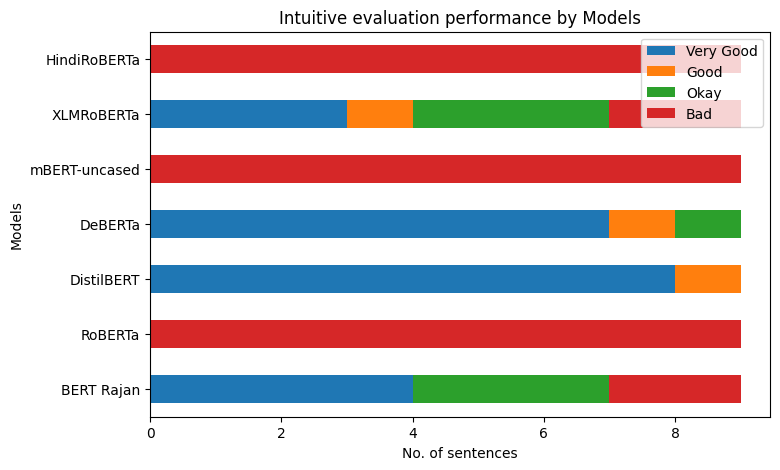

In [86]:
count_df[['BERT Rajan', 'RoBERTa', 'DistilBERT', 'DeBERTa', 'mBERT-uncased', 'XLMRoBERTa', 'HindiRoBERTa']].transpose()[count_df[['BERT Rajan', 'RoBERTa', 'DistilBERT', 'DeBERTa', 'mBERT-uncased', 'XLMRoBERTa', 'HindiRoBERTa']].transpose().columns].plot.barh(stacked=True,
                                    title='Intuitive evaluation performance by Models',
                                    figsize=(8, 5), 
                                    xlabel='No. of sentences', 
                                    ylabel='Models', 
                                    # color=['lightseagreen', 'lightsteelblue', 'navajowhite', 'indianred']
                                    # cmap='viridis'
                               )

<AxesSubplot: >

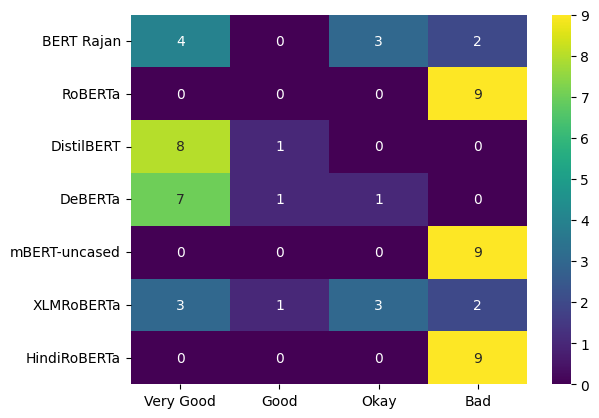

In [73]:
sns.heatmap(count_df[['BERT Rajan', 'RoBERTa', 'DistilBERT', 'DeBERTa', 'mBERT-uncased', 'XLMRoBERTa', 'HindiRoBERTa']].transpose(), 
            annot=True, 
            cmap='viridis')

<AxesSubplot: >

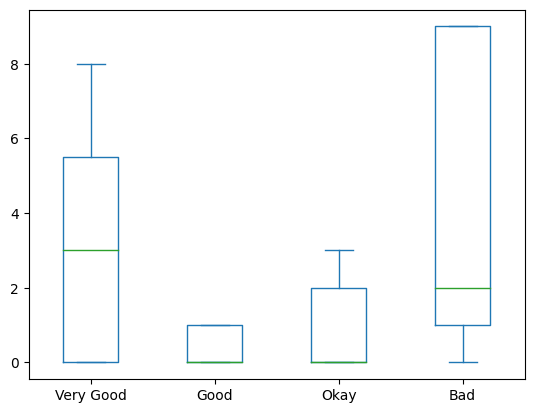

In [90]:
count_df[['BERT Rajan', 'RoBERTa', 'DistilBERT', 'DeBERTa', 'mBERT-uncased', 'XLMRoBERTa', 'HindiRoBERTa']].transpose().plot(kind='box')

In [84]:
(0.875-0.8738)/0.875

0.0013714285714285473

In [102]:
result_num_df = result_df[['BERT Rajan', 'RoBERTa', 'DistilBERT', 'DeBERTa', 'mBERT-uncased', 'XLMRoBERTa', 'HindiRoBERTa']].copy()

In [103]:
for column in result_num_df.columns:
    result_num_df[column].replace(['Bad', 'Okay', 'Good', 'Very Good'], [1, 2, 3, 4], inplace=True)

In [104]:
result_df

,BERT Rajan,BERT Shushant,BERT NpVec1,BERT Oya,RoBERTa,DistilBERT,DeBERTa,mBERT-uncased,XLMRoBERTa,HindiRoBERTa,mBERT-cased
0,Bad,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Bad,Bad,Bad
1,Bad,Okay,Bad,Bad,Bad,Very Good,Good,Bad,Good,Bad,Bad
2,Okay,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Okay,Bad,Bad
3,Very Good,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Okay,Bad,Bad
4,Okay,Bad,Bad,Bad,Bad,Good,Okay,Bad,Okay,Bad,Bad
5,Okay,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Very Good,Bad,Bad
6,Very Good,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Very Good,Bad,Bad
7,Very Good,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Very Good,Bad,Bad
8,Very Good,Bad,Bad,Bad,Bad,Very Good,Very Good,Bad,Bad,Bad,Bad


In [105]:
result_num_df

,BERT Rajan,RoBERTa,DistilBERT,DeBERTa,mBERT-uncased,XLMRoBERTa,HindiRoBERTa
0,1,1,4,4,1,1,1
1,1,1,4,3,1,3,1
2,2,1,4,4,1,2,1
3,4,1,4,4,1,2,1
4,2,1,3,2,1,2,1
5,2,1,4,4,1,4,1
6,4,1,4,4,1,4,1
7,4,1,4,4,1,4,1
8,4,1,4,4,1,1,1


<AxesSubplot: >

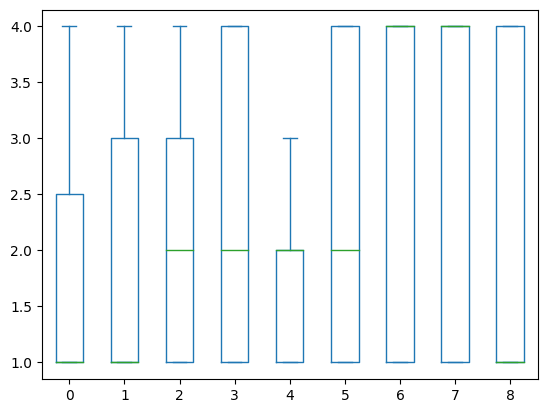

In [106]:
result_num_df[['BERT Rajan', 'RoBERTa', 'DistilBERT', 'DeBERTa', 'mBERT-uncased', 'XLMRoBERTa', 'HindiRoBERTa']].transpose().plot(kind='box')